In [1]:
"""
Data Loading.
"""

'\nData Loading.\n'

In [2]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import sys
import shapely

In [3]:
%%time
stops_path = "./Data/Transit_Stops/Transit_Stops_for_King_County_Metro__transitstop_point.shp"
stops = gpd.read_file(stops_path)

CPU times: user 13.7 s, sys: 260 ms, total: 13.9 s
Wall time: 13.8 s


In [4]:
%%time
signals_path = "./Data/Signals/KCM_signals.shp"
signals = gpd.read_file(signals_path)

CPU times: user 227 ms, sys: 4.14 ms, total: 231 ms
Wall time: 224 ms


In [5]:
%%time
# Can I make this more time efficient?
kc_streets_path = "./Data/Seattle_Streets/KCM_Streets.shp"
kc_streets = gpd.read_file(kc_streets_path)

CPU times: user 54.2 s, sys: 782 ms, total: 55 s
Wall time: 54.5 s


In [6]:
%%time
kcm_routes_path = "./Data/Routes/Comprehensive_Routes/KCM_Routes.shp"
kcm_routes = gpd.read_file(kcm_routes_path)

CPU times: user 259 ms, sys: 3.99 ms, total: 263 ms
Wall time: 259 ms


In [7]:
%%time
accel_prof_path = "./Data/Accel_Prof/acceleration.csv"
raw_acc_prof = pd.read_csv(accel_prof_path, names=['time[s]', 'accel.[g]'])

CPU times: user 1.99 ms, sys: 206 μs, total: 2.2 ms
Wall time: 2.21 ms


In [8]:
%%time
all_stops = stops.copy()

all_signals = signals['geometry'].reset_index(drop = True)

all_limits = kc_streets[['geometry','SPEED_LIM']]


CPU times: user 21.8 ms, sys: 0 ns, total: 21.8 ms
Wall time: 21.1 ms


In [183]:
def get_bounding_box(shape):
    bbox_cords = shape.bounds
    boundary_coords = ((bbox_cords[0], bbox_cords[1]),
                 (bbox_cords[0], bbox_cords[3]),
                 (bbox_cords[2], bbox_cords[3]),
                 (bbox_cords[2], bbox_cords[1]))
    return shapely.Polygon(boundary_coords)

In [184]:
route_boundaries = get_bounding_box(shapely.LineString(gpd.read_file('./Data/Routes/Individual_Routes/rt22_pts.shp')['geometry']))

In [190]:
%%time
print(len(all_limits))
copy_limits = all_limits.copy()
copy_limits['in_bounds'] = copy_limits['geometry'].apply(get_bounding_box).apply(lambda x: shapely.contains(route_boundaries, x))
copy_limits = copy_limits[copy_limits['in_bounds'] == True]
print(len(copy_limits))

143755
1712
CPU times: user 3.09 s, sys: 3.83 ms, total: 3.1 s
Wall time: 3.09 s


In [176]:
shapely.overlaps(route_boundaries, street_bounds)

False

<Axes: >

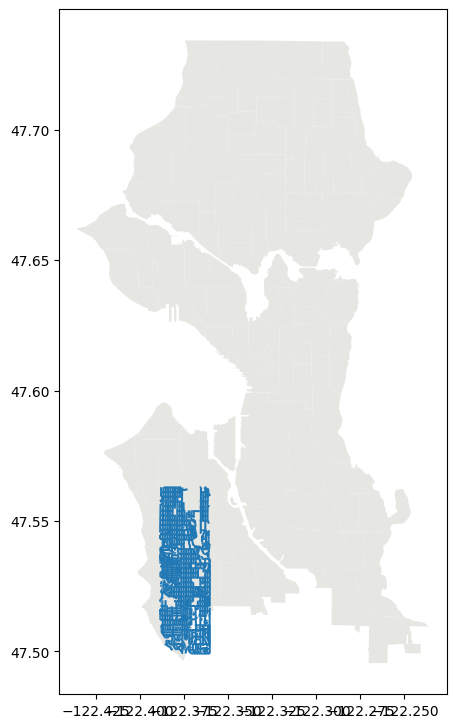

In [191]:
# Display a map of the route overlayed over area data:
# Import area map:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

# set up a figure:
fig, ax = plt.subplots(1, figsize = (5,10))

# Plot the map of the area:
seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)
copy_limits.plot(ax=ax, markersize=1)
#all_signals.plot(ax = ax, c="tab:orange", markersize=1)

# Landscape elevation +/= Road elevation - Vehicle dynamic models need the road elevation

In [9]:
def separate_period_ridership(rider_df):
    '''
    separate_period_ridership splits a dataframe containing ridership information,
    and then generates the mean ridership change per stop for a given period.
    
    '''
    
    # Generate an empty dictonary
    dict_list = {}
    
    # loop through each ridership period
    for period in rider_df['Period'].unique():
        
        # Get the ridership for the current period
        period_ridership = rider_df[rider_df['Period']==period]
        
        # sort the ridership by filtering the Inbound/Outbound, trip id, stop sequence, and stop ID
        sorted_riders = period_ridership.sort_values(by=['InOut','Trip_ID', 'STOP_SEQ', 'STOP_ID'])
        sorted_riders = sorted_riders[['InOut','STOP_SEQ', 'STOP_ID', 'AveOn', 'AveOff', 'AveLd']]
        
        # Remove any duplicates
        sorted_riders = sorted_riders.drop_duplicates(subset=['InOut','STOP_SEQ'], keep='first')
        sorted_riders = sorted_riders.drop_duplicates(subset='STOP_ID', keep='first')
        sorted_riders = sorted_riders.reset_index(drop = True)
        
        # Get the index
        sorted_riders['Index'] = sorted_riders.index
 
        # get the difference in ridership mean
        values = sorted_riders['AveOn'] - sorted_riders['AveOff']
        
        # create a dictionary of stop IDs and ridership mean changes
        stop_ids = sorted_riders['STOP_ID']
        sorted_riders_diff = dict(zip(stop_ids, values))
        
        # append the ridership changes to the dictionary
        dict_list[period] = sorted_riders_diff
    
    # return the dictionary
    return dict_list

In [10]:
def filter_stops_by_ridership(rider_sep, route_stops):
    '''
    filter_stops_by_ridership takes the ridership for the route and the stop ID's,
    then filters all the stops on the route to only include those witha ridership change.
    '''
    
    # Create an empty dictionary
    dict_list = {}
    
    # get the periods for the ridership and cycle through them
    for period in rider_sep.keys():

        # get the ridership stop id's
        rider_stops = list(rider_sep[period].keys())
        
        matched_stops = pd.DataFrame(columns=['t'], index=rider_stops)
        
        # get all of the route stops that have ridership data
        matched_stops_pre = route_stops[route_stops['STOP_ID'].isin(rider_stops)]
        
        # set the stop index to the IDs and then sort the stops to align with the ridership info
        matched_stops_pre = matched_stops_pre.set_index(matched_stops_pre['STOP_ID'])
        
        matched_stops = (matched_stops.join(matched_stops_pre))[['STOP_ID', 'geometry']]
        
        matched_stops = matched_stops.loc[rider_stops]
        
        dict_list[period] = {}
        dict_list[period] = dict(zip(matched_stops['STOP_ID'], matched_stops['geometry']))
        
    return dict_list

In [11]:
#kcm_ridership[(kcm_ridership['STOP_ID'] == 55938) & (kcm_ridership['Route'] == 101) & (kcm_ridership['Period'] == 'AM')]

In [12]:
import os
import Helper_Methods as hm
#variable for route sampling:
route_concat_val = 6 # every 6th point in the data is used

# get the available route shapefiles
route_data_dir = "./Data/Routes/Individual_Routes/"
routefiles_raw = pd.Series(os.listdir(route_data_dir))
routefiles = routefiles_raw[routefiles_raw.apply(lambda x: ('shp' in (x.split("."))[-1]))].reset_index(drop='true')
routefiles = routefiles.apply(lambda x: "{}{}".format(route_data_dir, x))

# get the ridership data
ridership_path = "./Data/Trip_Data/Zon183Unsum.csv"
kcm_ridership = pd.read_csv(ridership_path)

data_dict_list = {}

print("Available Routes:")
for route in routefiles:
    
    # read the route shape
    route_shape = gpd.read_file(route)
    
    # get the sampled route
    route_sampled = route_shape[::route_concat_val].reset_index(drop=True)
    
    # Get the route geometry 
    route_geometry = route_sampled['geometry']
    
    # Get the elevation
    route_elevation = route_sampled['Z']
    
    # pull the route number
    route_num = (route.split('rt')[-1]).split("_")[0]
    
    # get the ridership for the specific route
    rider_df = kcm_ridership[(kcm_ridership['Route']==int(route_num))]
    
    # Separate the ridership into periods
    rider_sep = separate_period_ridership(rider_df)
    
    # Separate the route bus stops by filtering them to only the ones with ridership changes
    route_stops = (hm.get_stops(all_stops, str(route_num)))[['geometry','STOP_ID']].reset_index(drop=True)
    filtered_stops = filter_stops_by_ridership(rider_sep, route_stops)
    
    # 
    data_dict = {"geometry":route_geometry,
                 "elevation":route_elevation,
                 "ridership":rider_sep,
                 "stops":filtered_stops}
    data_dict_list[route_num] = data_dict
    print("\t{}".format(route_num))

Available Routes:
	22
	186
	101


In [13]:
print(data_dict_list['101']['ridership']['MID'].keys())
print(data_dict_list['101']['stops']['MID'].keys())

dict_keys([55938, 55939, 46466, 46468, 46472, 45301, 45320, 79520, 79530, 79540, 79555, 79560, 99252, 99254, 99264, 99267, 621, 532, 565, 1121, 1075, 1080, 1108, 455, 501, 623, 99271, 99266, 99263, 99253, 79570, 79580, 79590, 79600, 79610, 46440, 46450, 45303, 45285, 45288, 59841, 59839])
dict_keys([55938.0, 55939.0, 46466.0, 46468.0, 46472.0, 45301.0, 45320.0, 79520.0, 79530.0, 79540.0, 79555.0, 79560.0, 99252.0, 99254.0, 99264.0, 99267.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 99271.0, 99266.0, 99263.0, 99253.0, 79570.0, 79580.0, 79590.0, 79600.0, 79610.0, 46440.0, 46450.0, 45303.0, 45285.0, 45288.0, 59841.0, nan])


In [14]:
import RouteMap as rm

# check the directory for saving the route maps
saved_list = os.listdir('./Data/SAVED_ROUTEMAPS/')

# check the route in the data dictionary 
for route in data_dict_list.keys():
    route_data = data_dict_list[route]
    route_data['map'] = {}
    # loop through each period 
    for period in route_data['stops']:
        
        
        routemap_name = 'route_map_{}_{}.csv'.format(route, period)
        route_map = None

        if routemap_name in saved_list:
            print('saved route found: {}'.format(routemap_name))
            route_map = rm.RouteMap(route_data['geometry'], route_data['elevation'])
            route_map = route_map.load_from_gdf('./Data/SAVED_ROUTEMAPS/{}'.format(routemap_name))
        else:
            print('generating route for {}, {}'.format(route, period))
            route_map = rm.RouteMap(route_data['geometry'],
                                    route_data['elevation'],
                                    all_limits,
                                    pd.Series(list(route_data['stops'][period].values())),
                                    all_signals,
                                    debug = True)
            route_map.get_gdf().to_csv('./Data/SAVED_ROUTEMAPS/{}'.format(routemap_name))
        route_data['map'][period]=route_map

generating route for 22, XEV
DEBUGGER ACTIVE


KeyError: 0

In [76]:
data_dict_list['22']['map']

{'XEV': <RouteMap.RouteMap at 0x764fe63a0380>,
 'AM': <RouteMap.RouteMap at 0x764fe6106690>,
 'MID': <RouteMap.RouteMap at 0x764fe6139d60>,
 'PM': <RouteMap.RouteMap at 0x764fe6390cb0>}

22
XEV


/tmp/ipykernel_5298/366496691.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45)
/tmp/ipykernel_5298/366496691.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45)


AM


/tmp/ipykernel_5298/366496691.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45)


MID


/tmp/ipykernel_5298/366496691.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45)


PM
186
AM


/tmp/ipykernel_5298/366496691.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45)
/tmp/ipykernel_5298/366496691.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45)


XEV


/tmp/ipykernel_5298/366496691.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45)


PM


/tmp/ipykernel_5298/366496691.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45)


MID


/tmp/ipykernel_5298/366496691.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=-45)


XNT
101


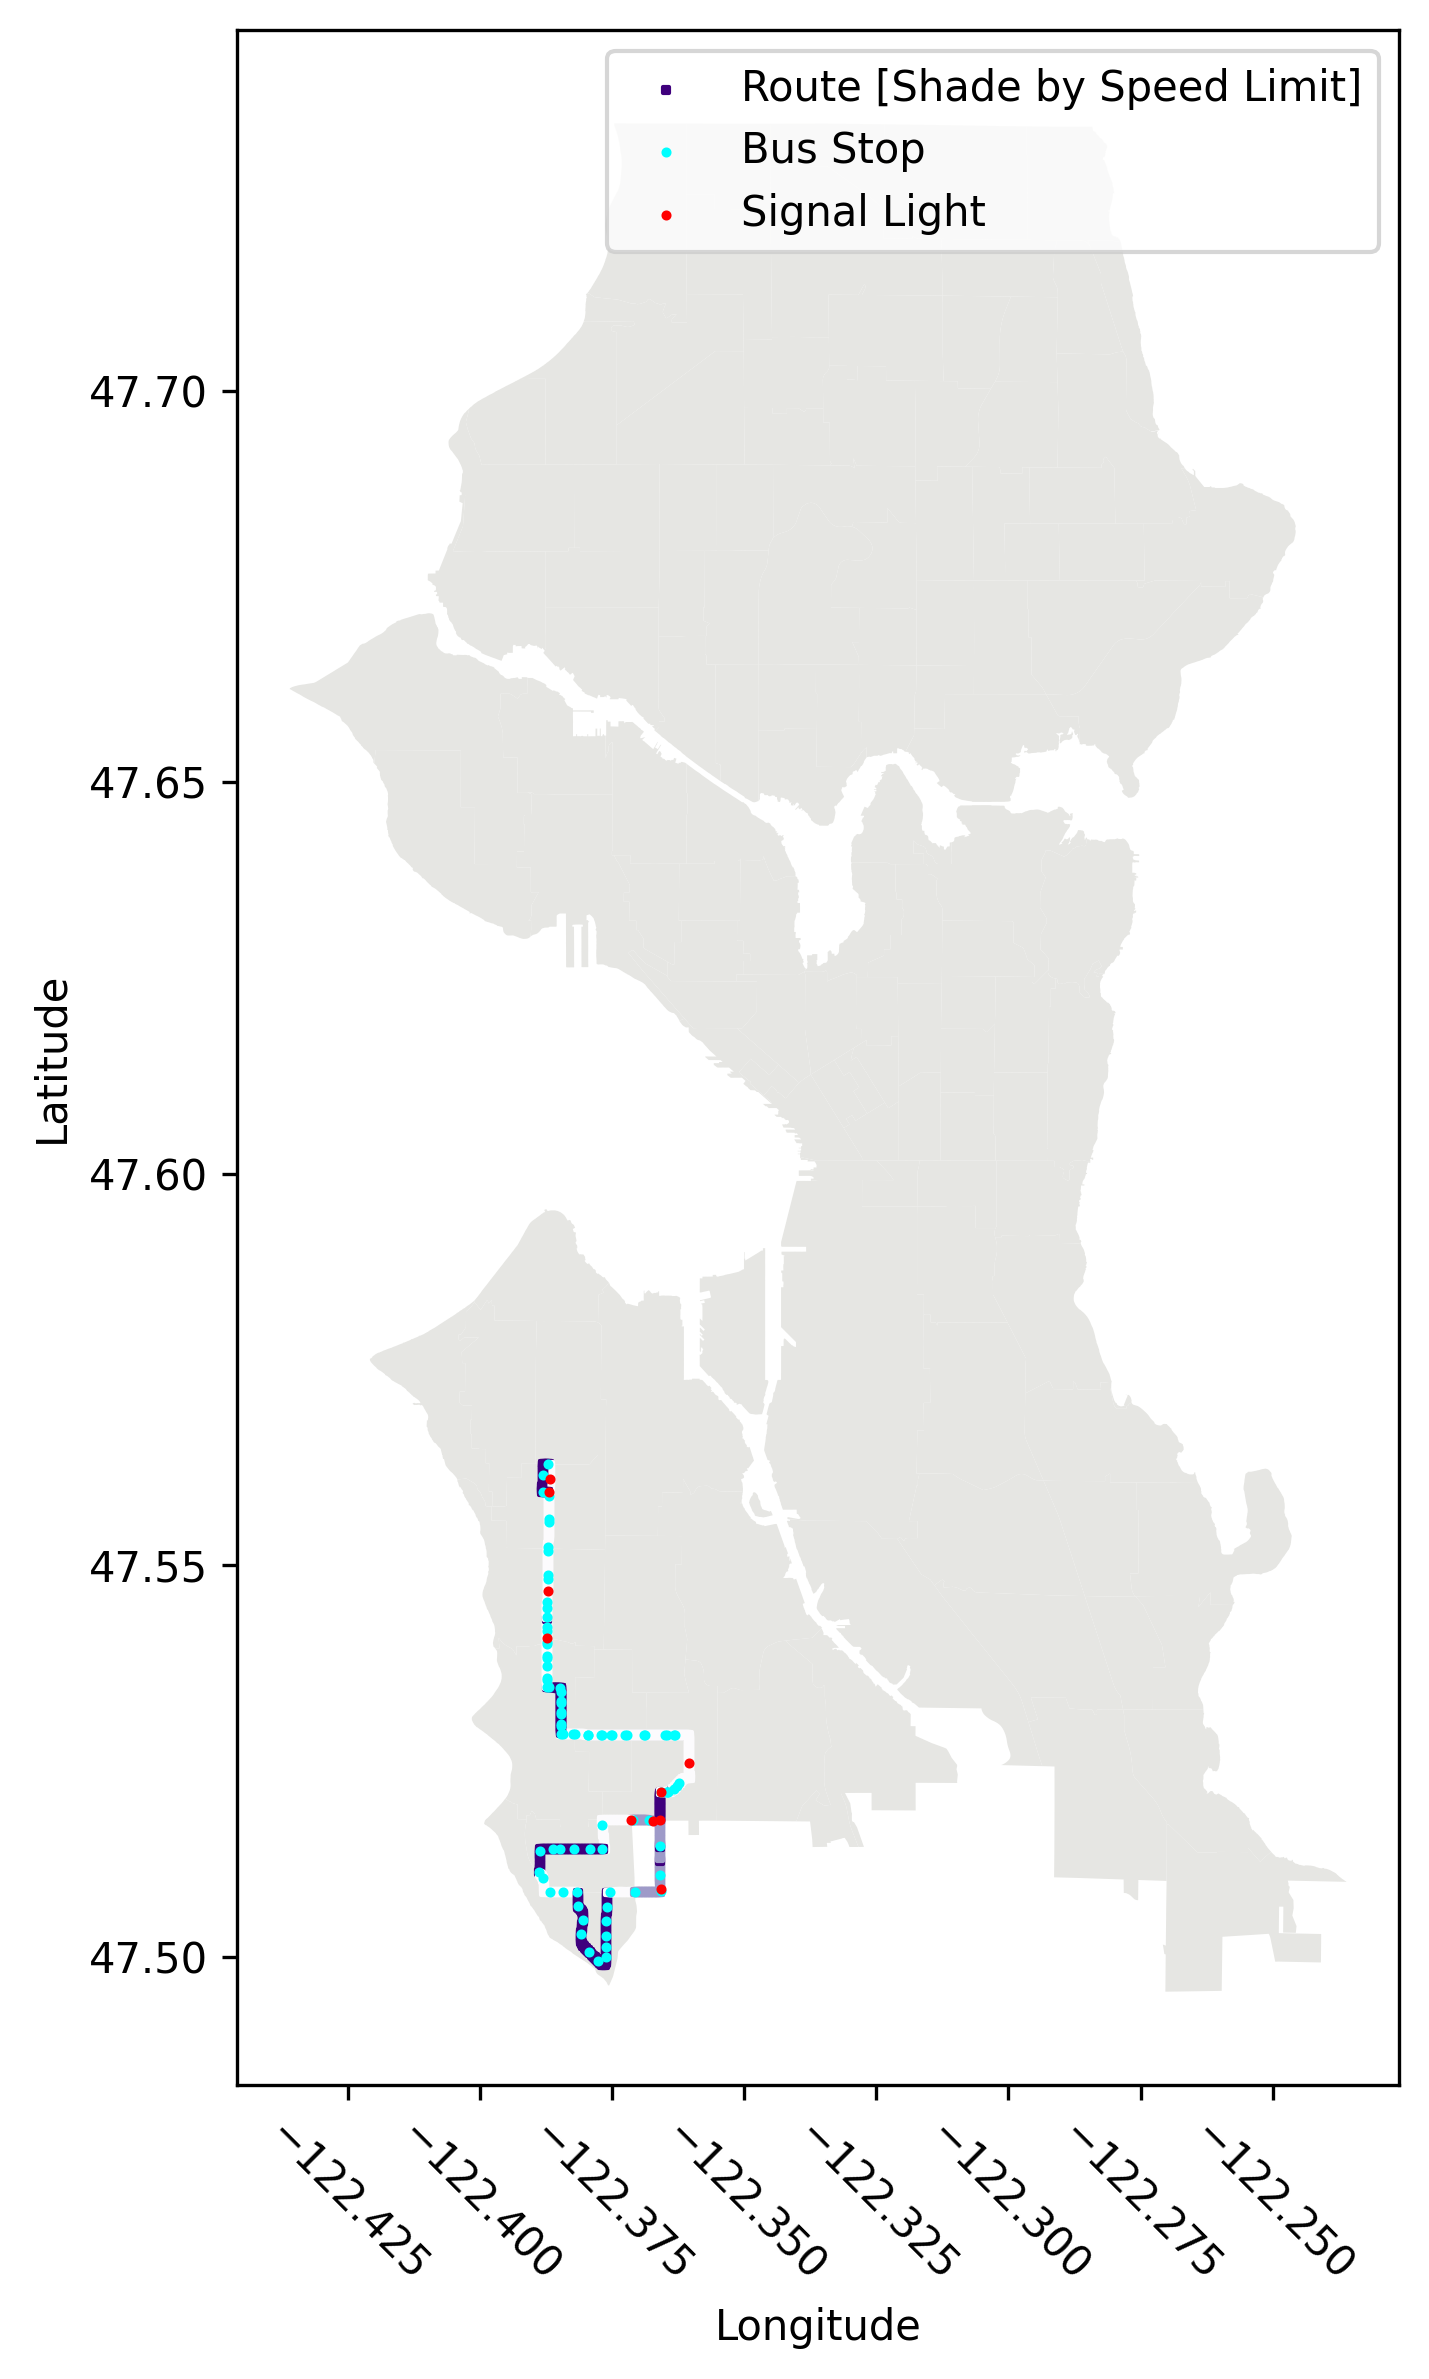

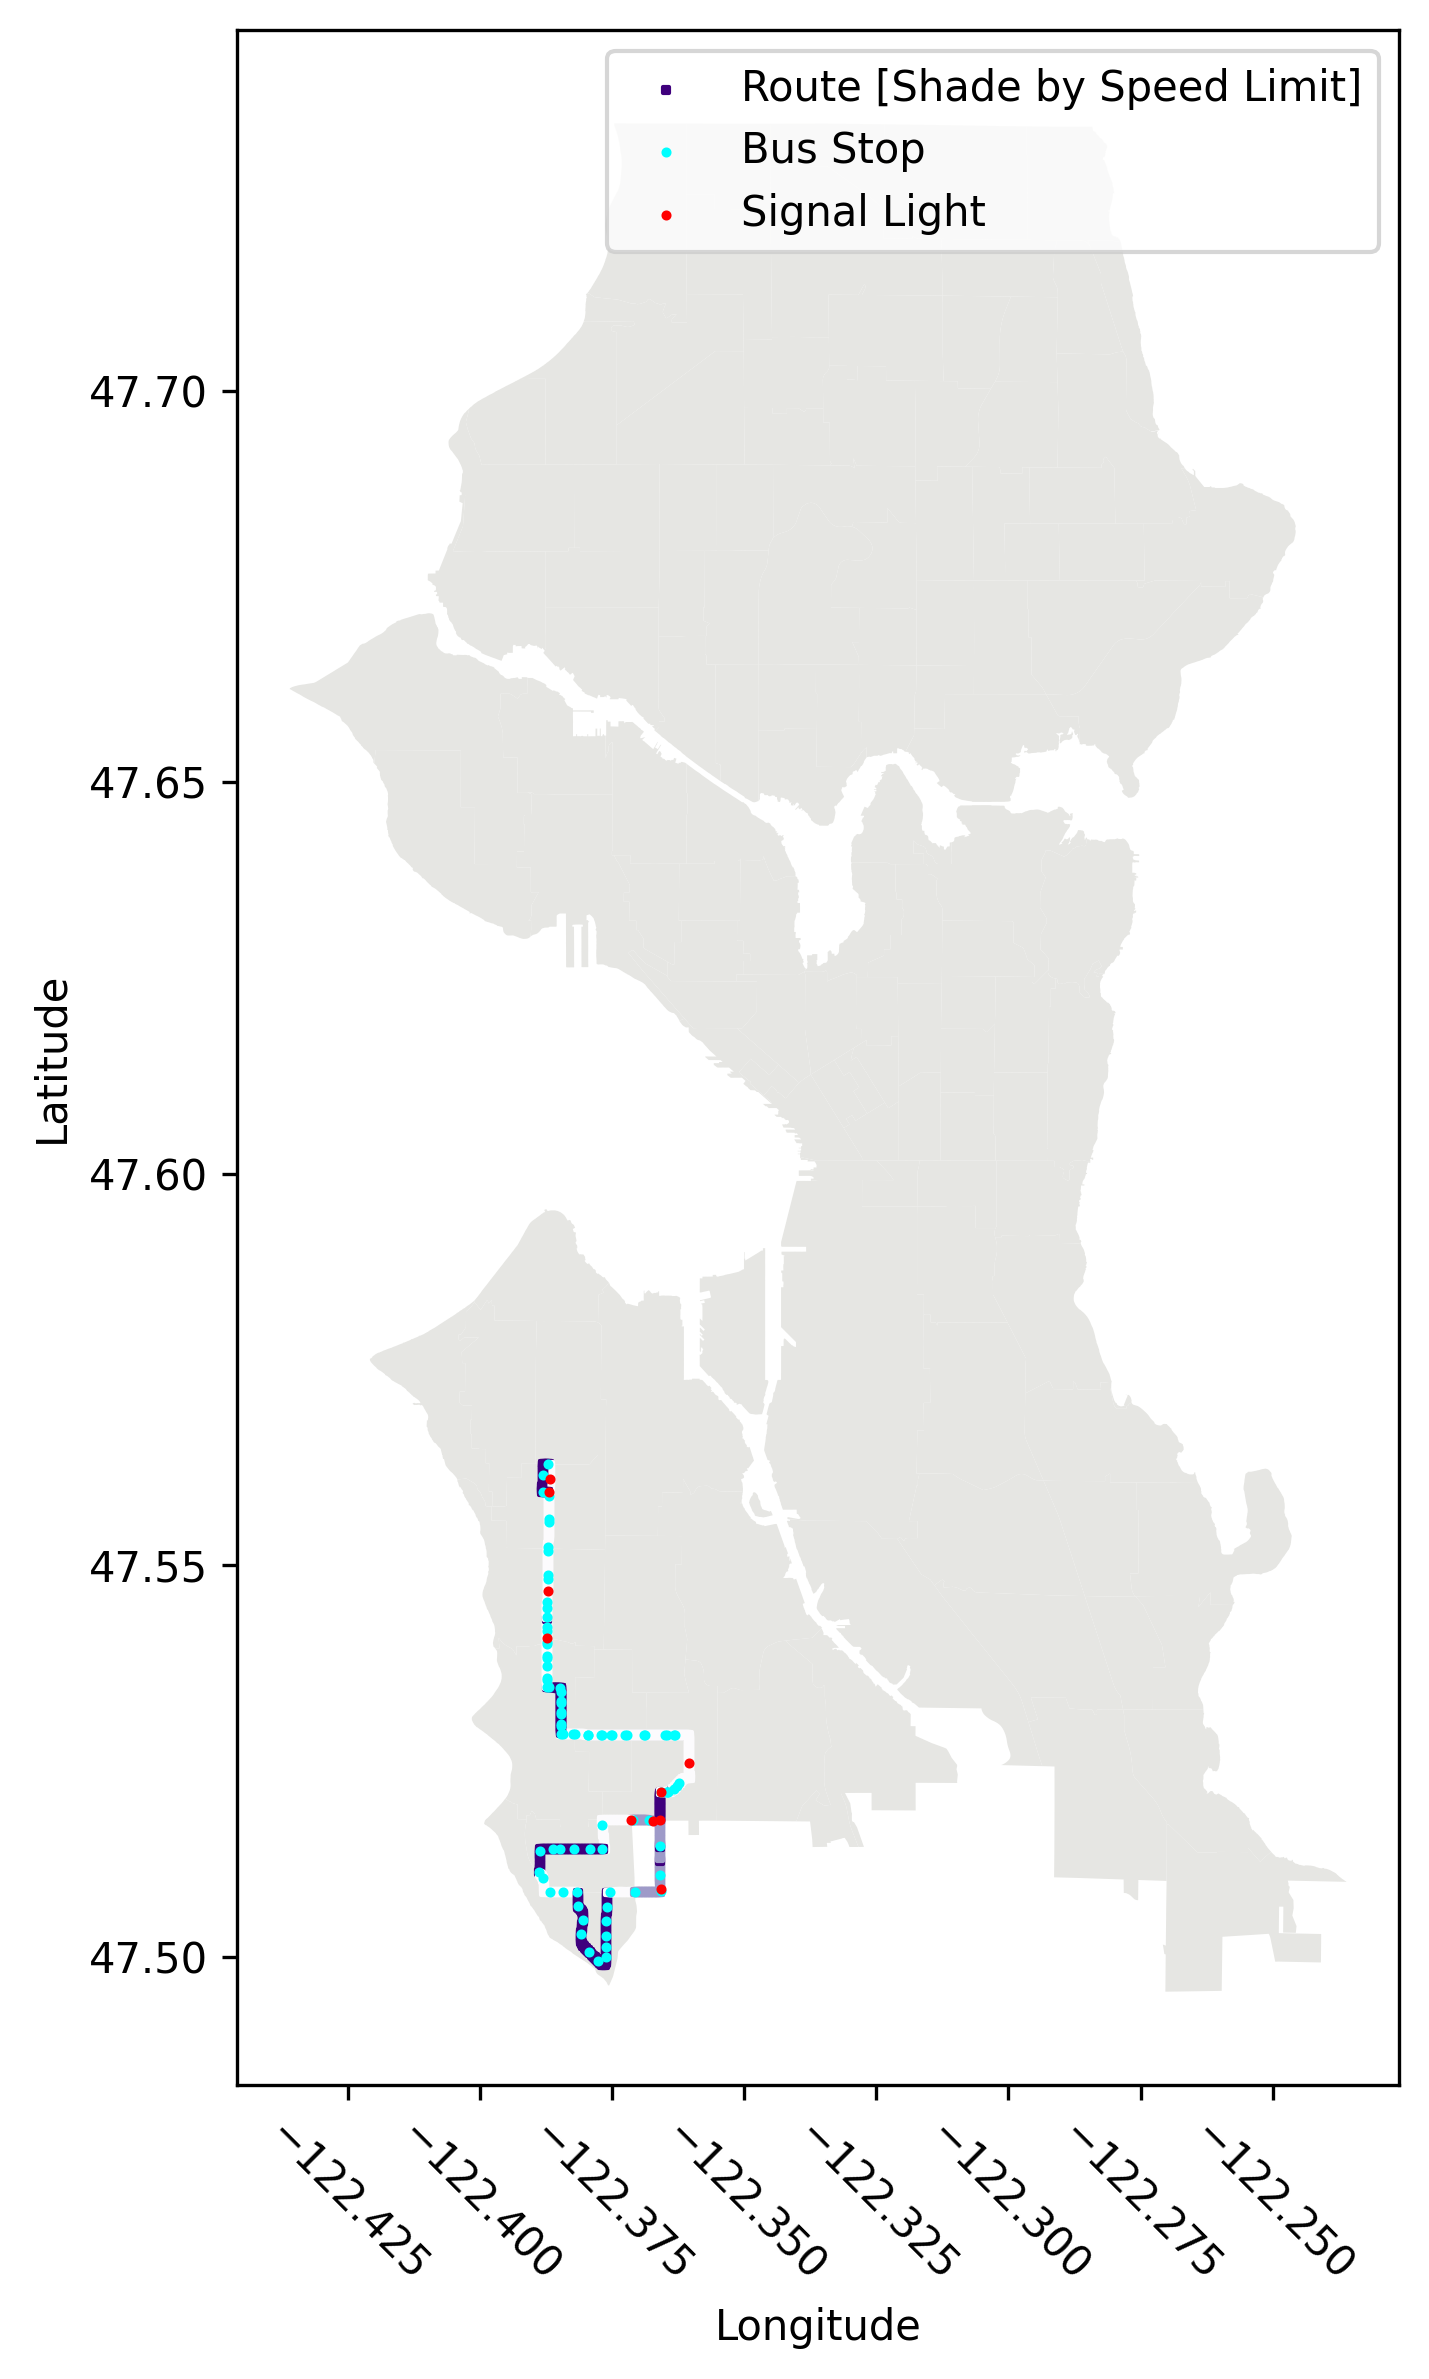

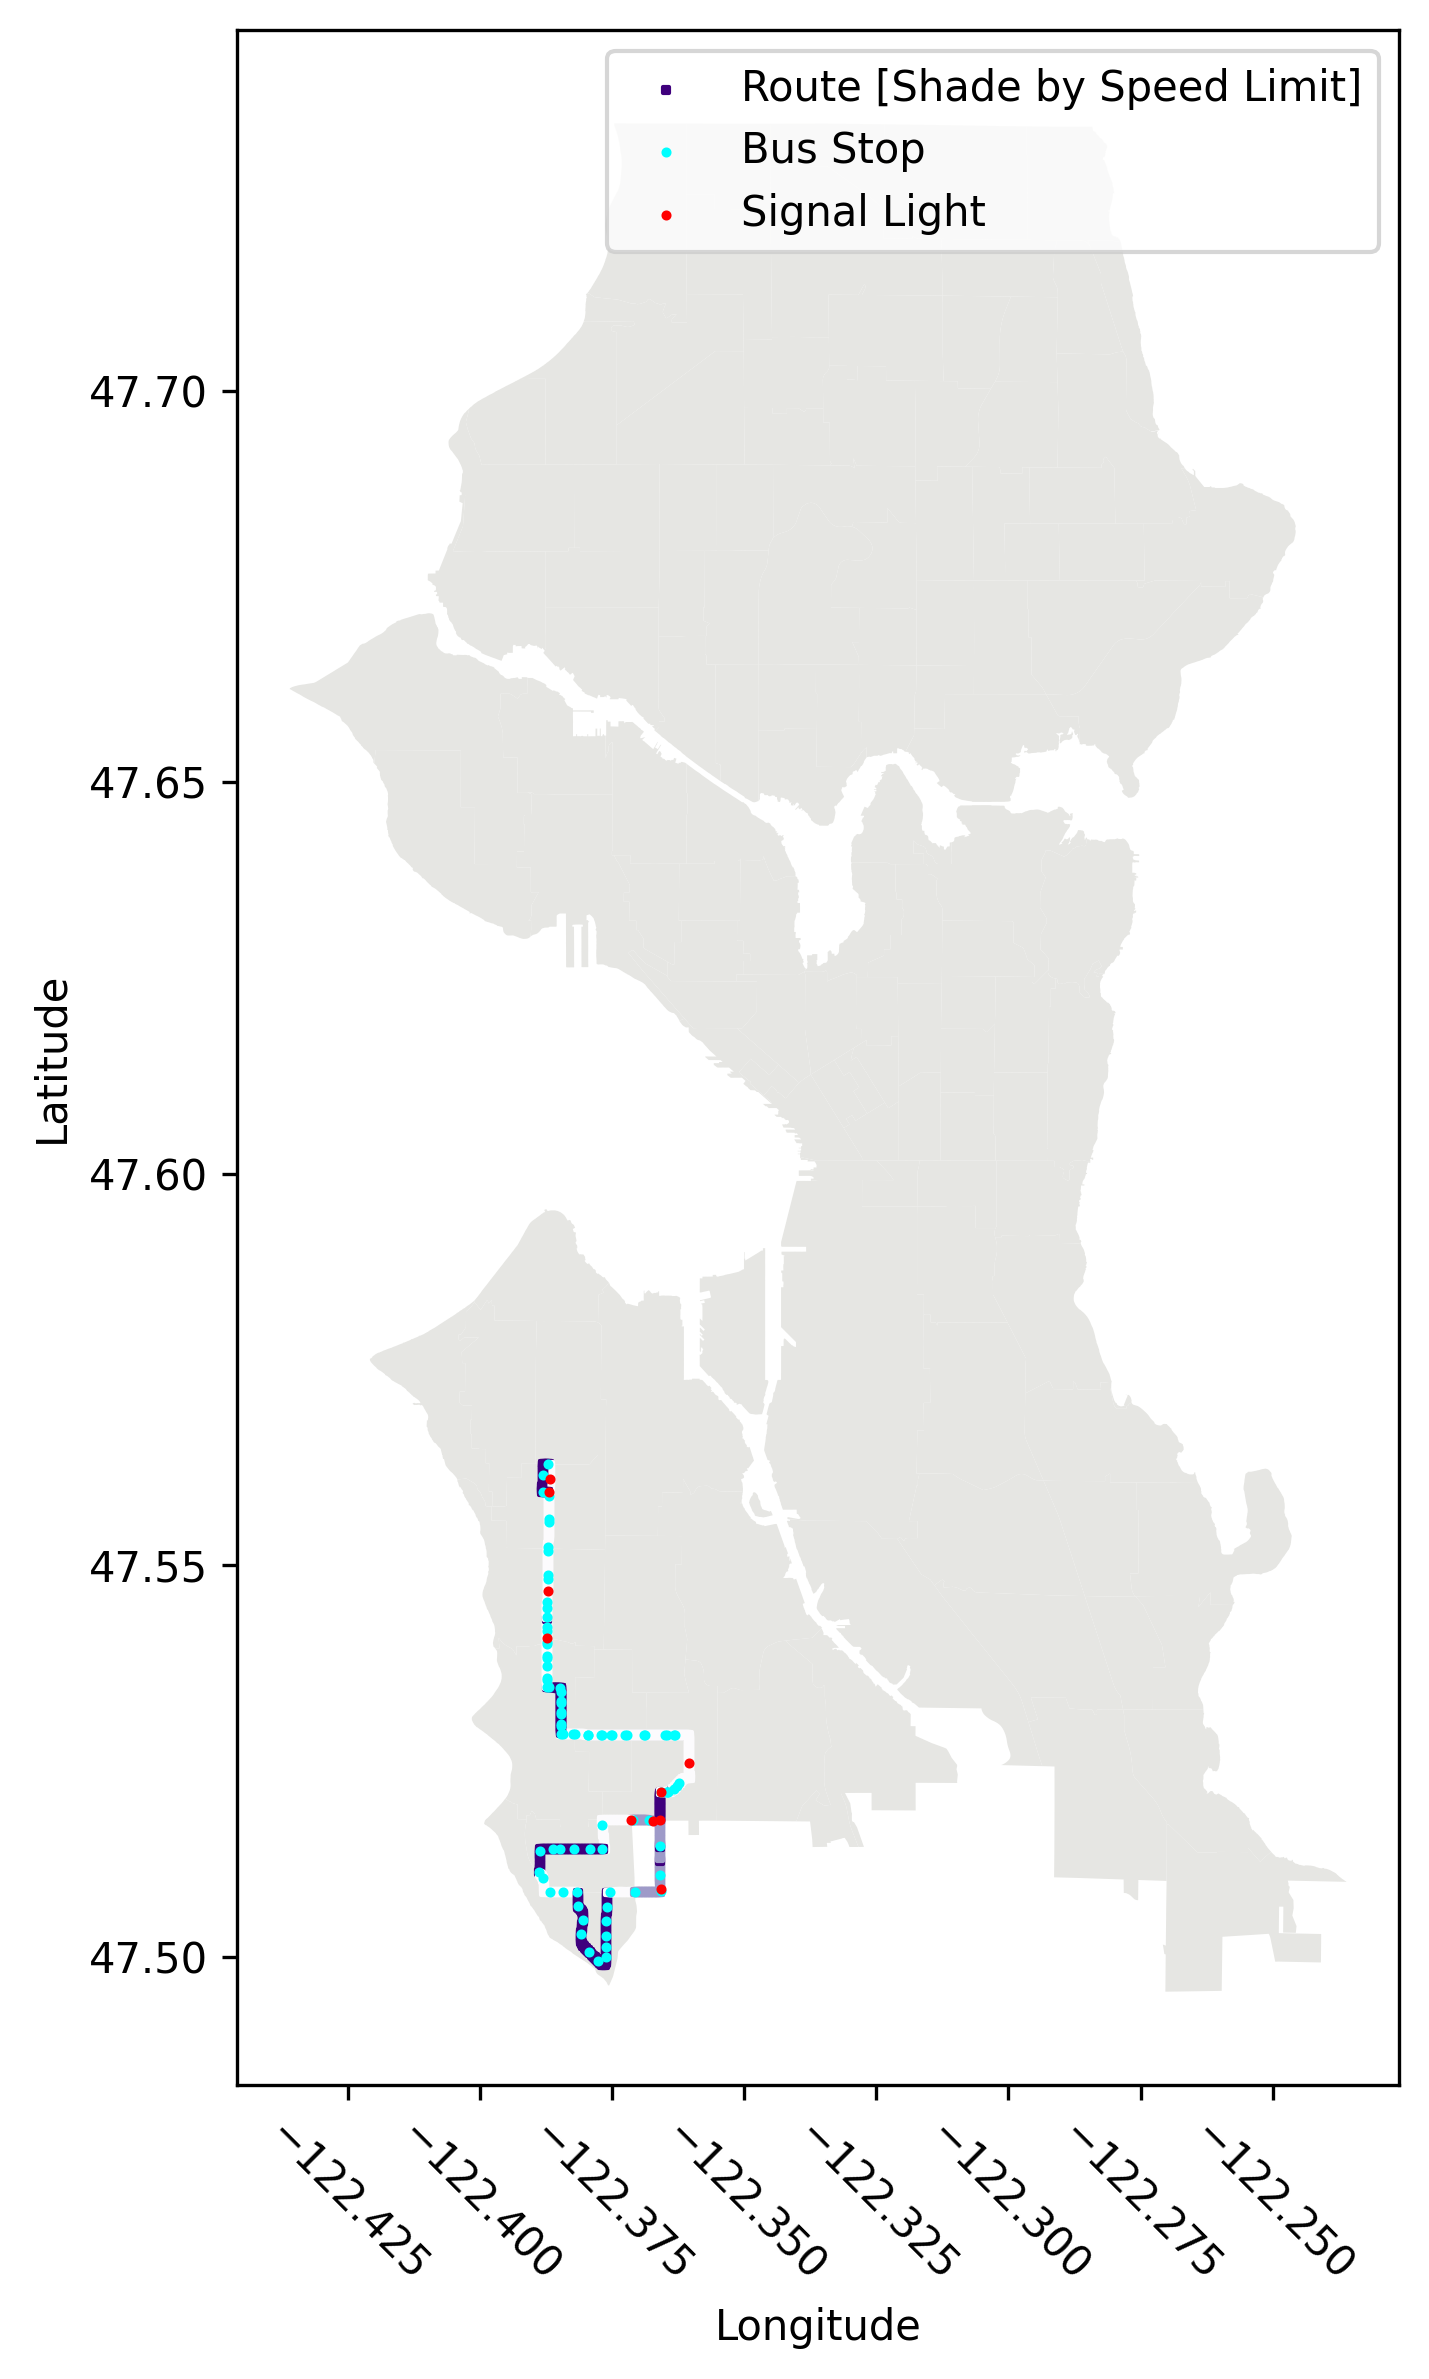

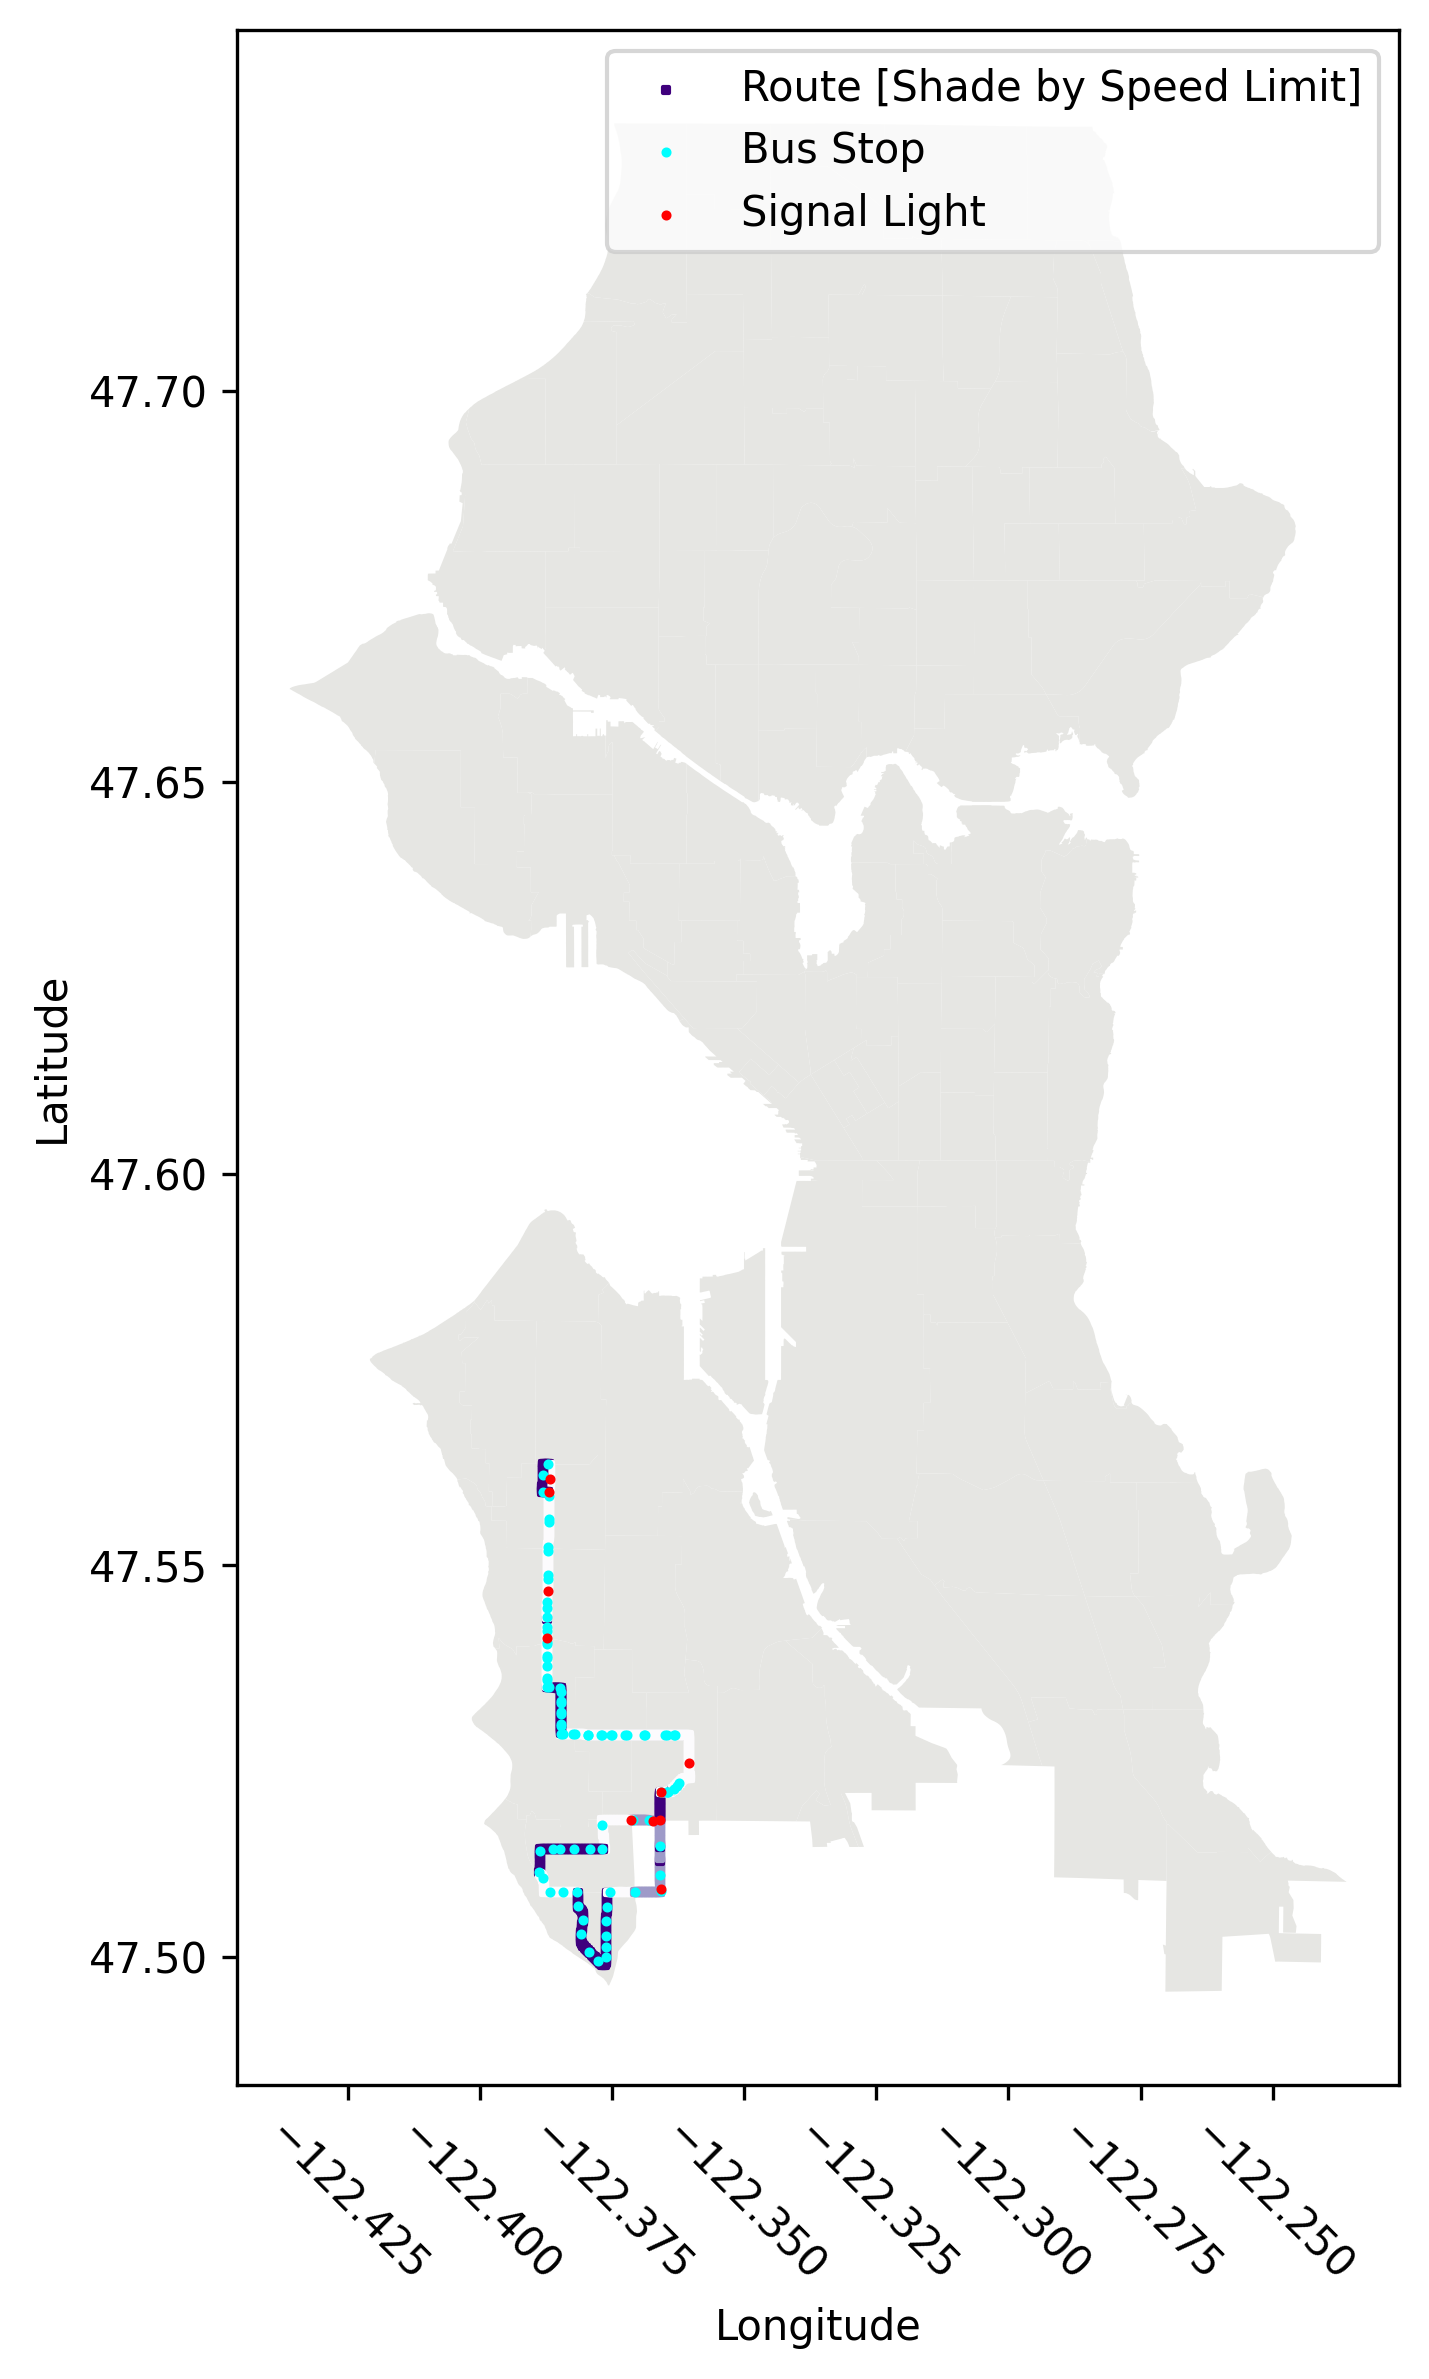

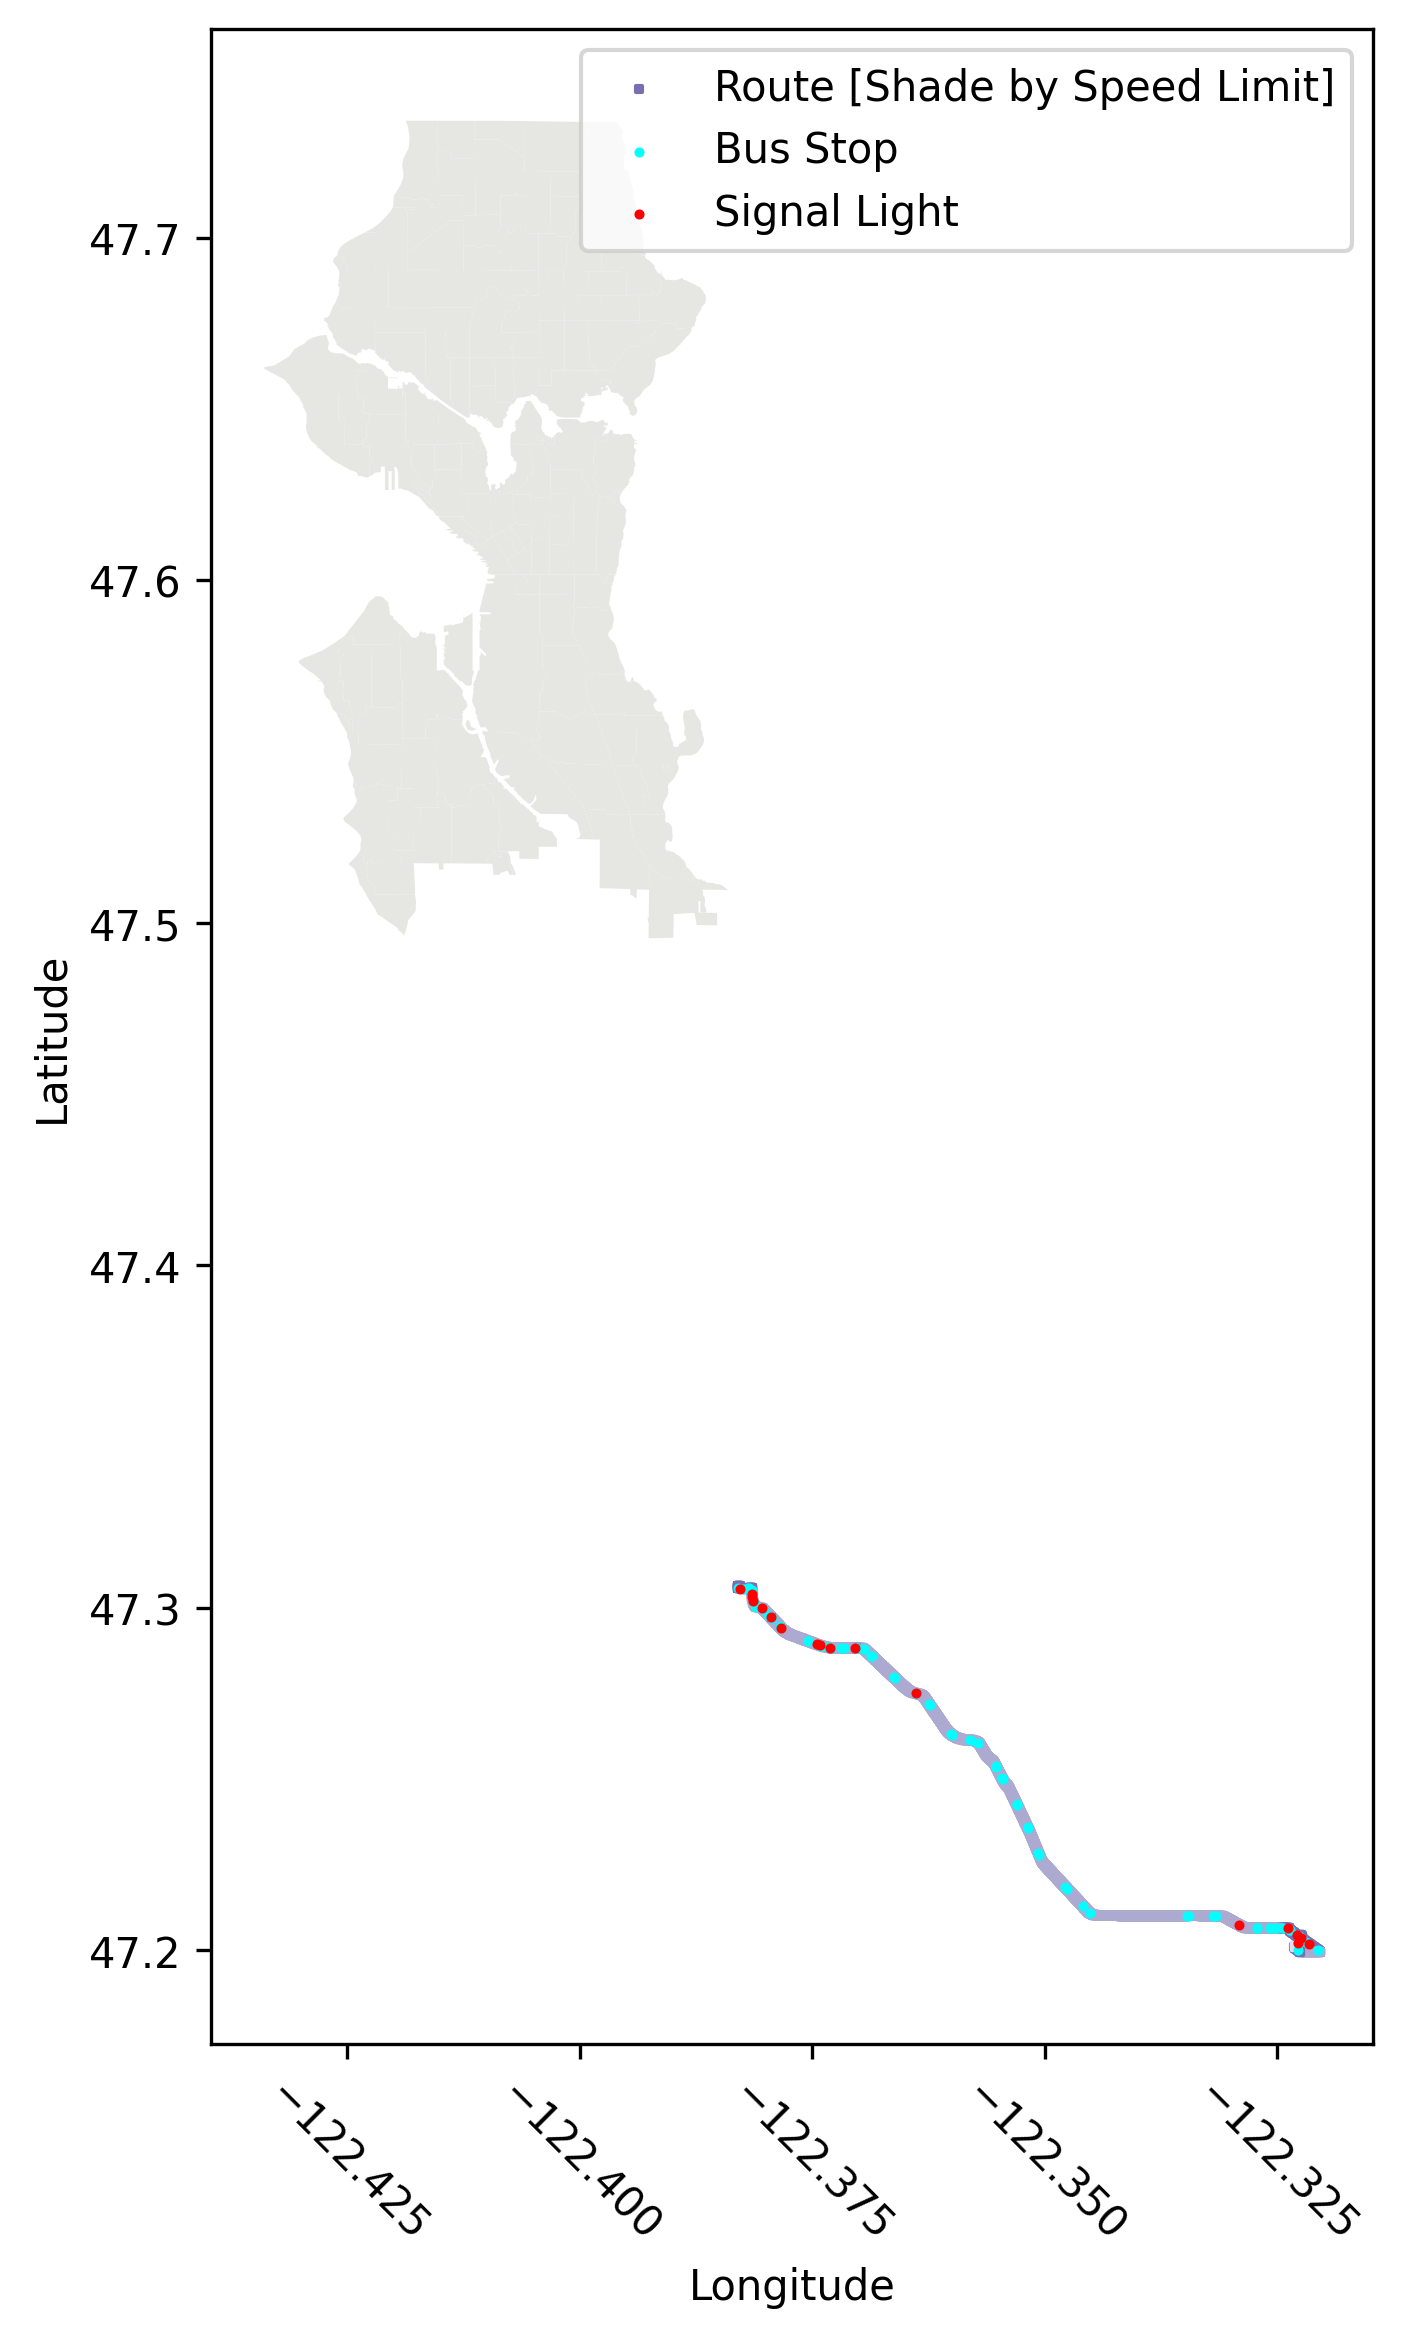

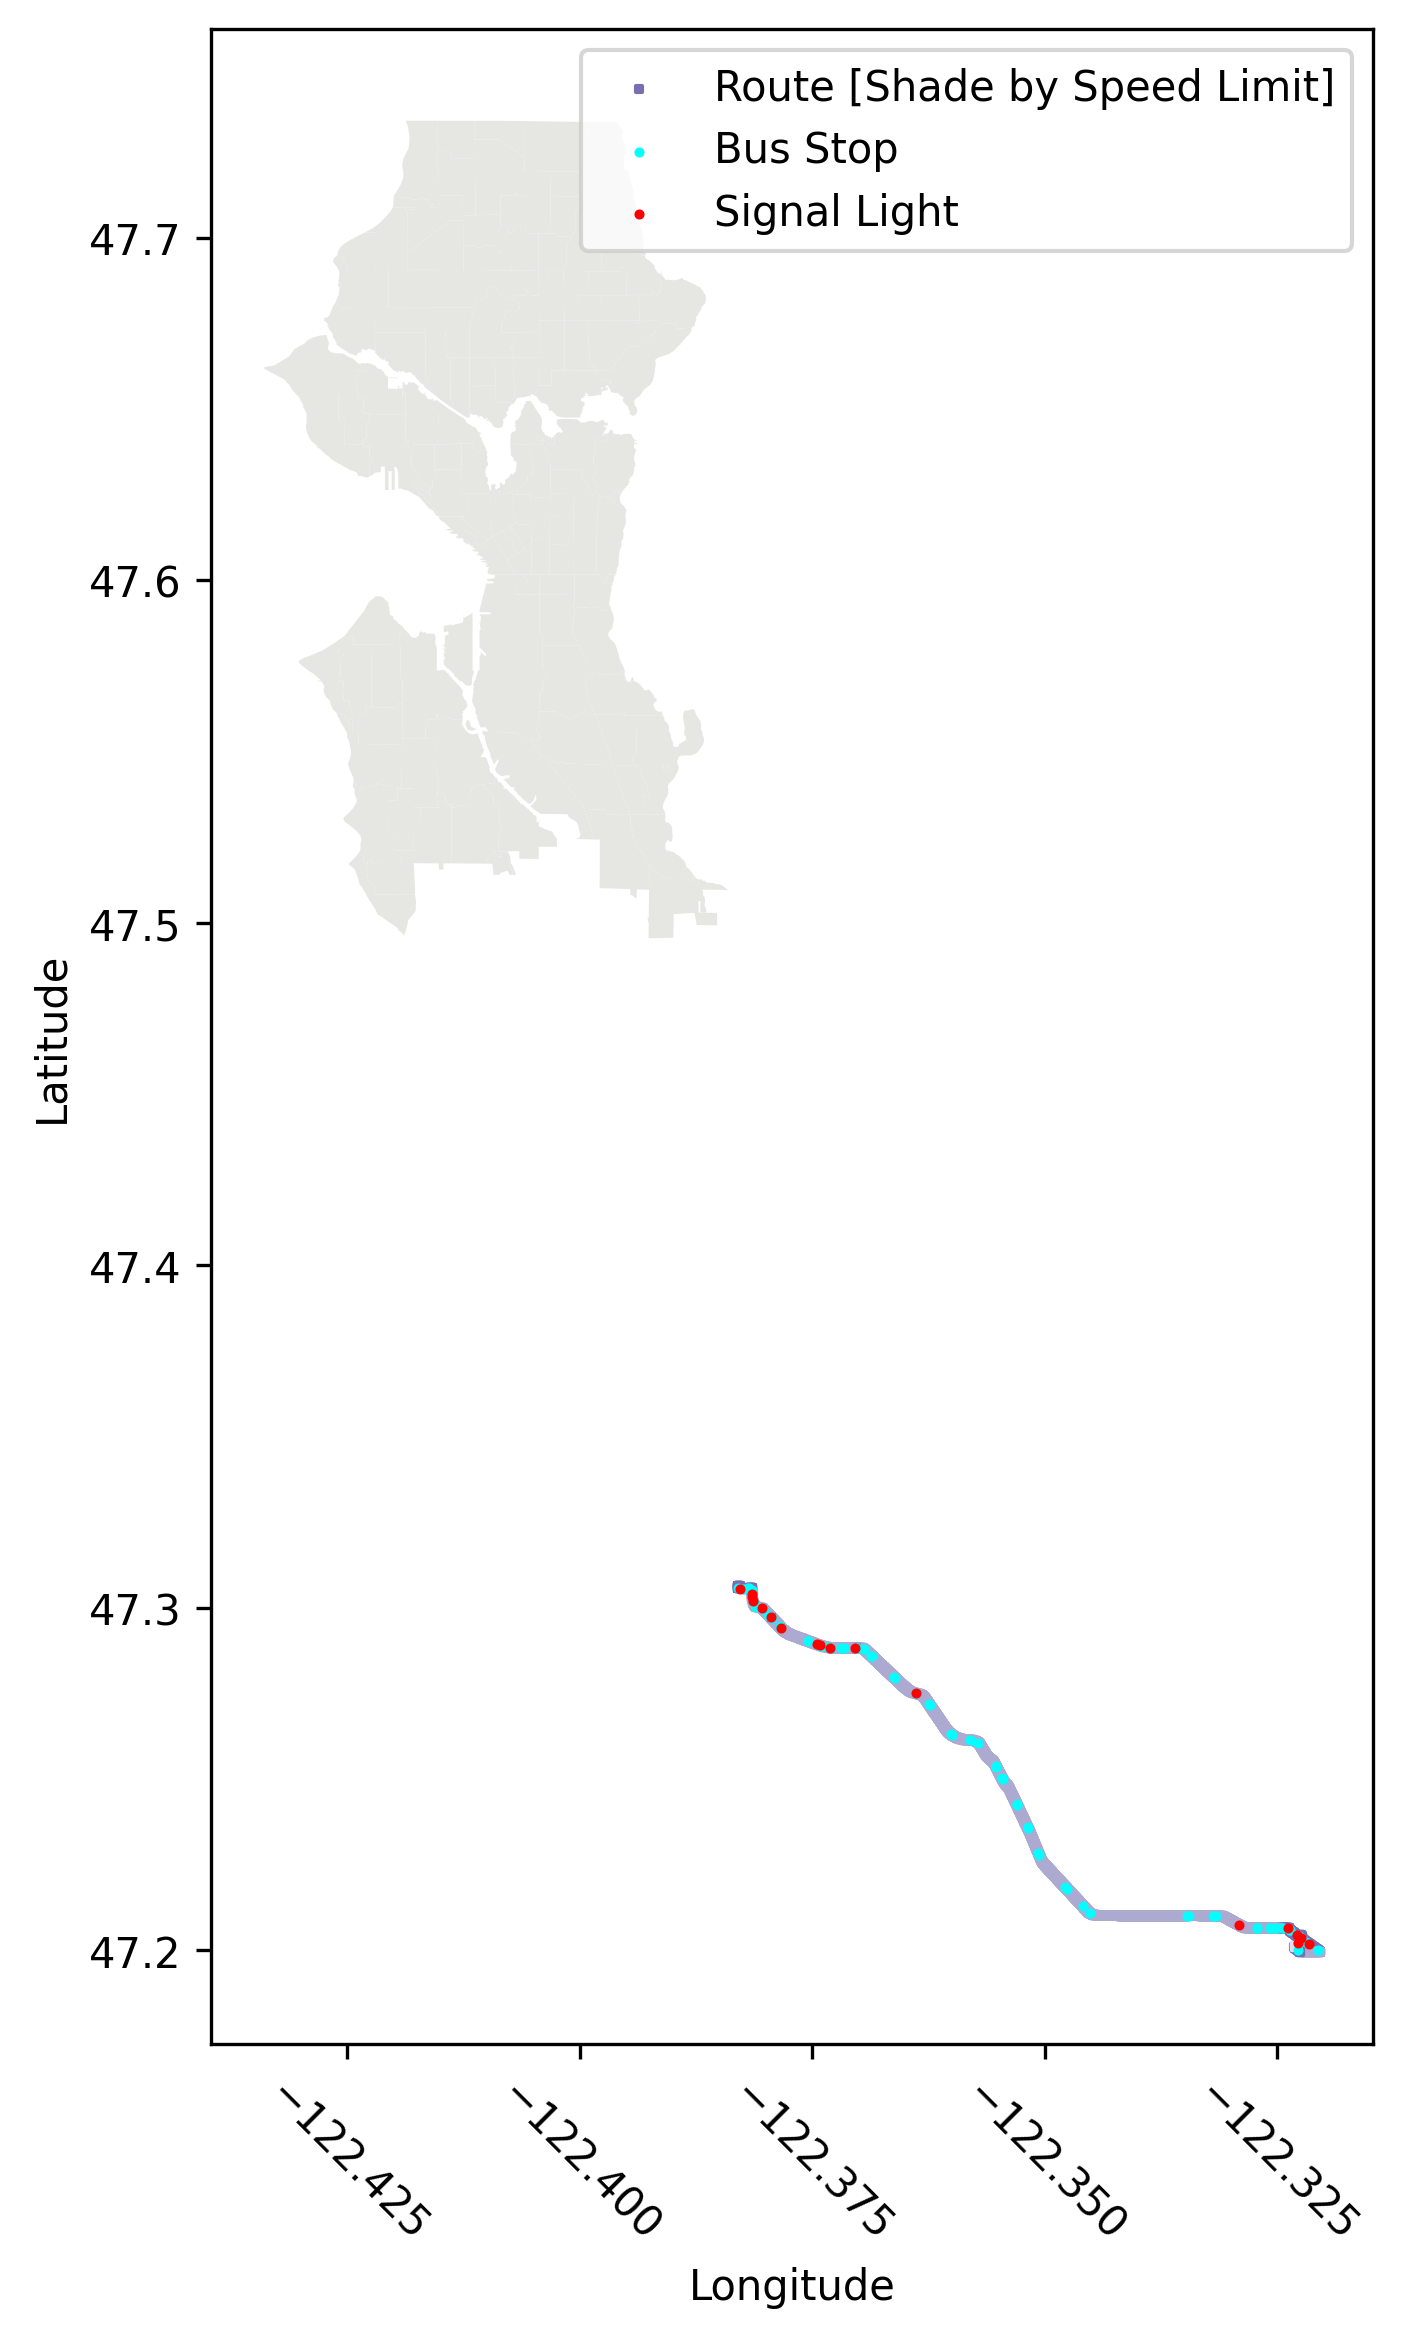

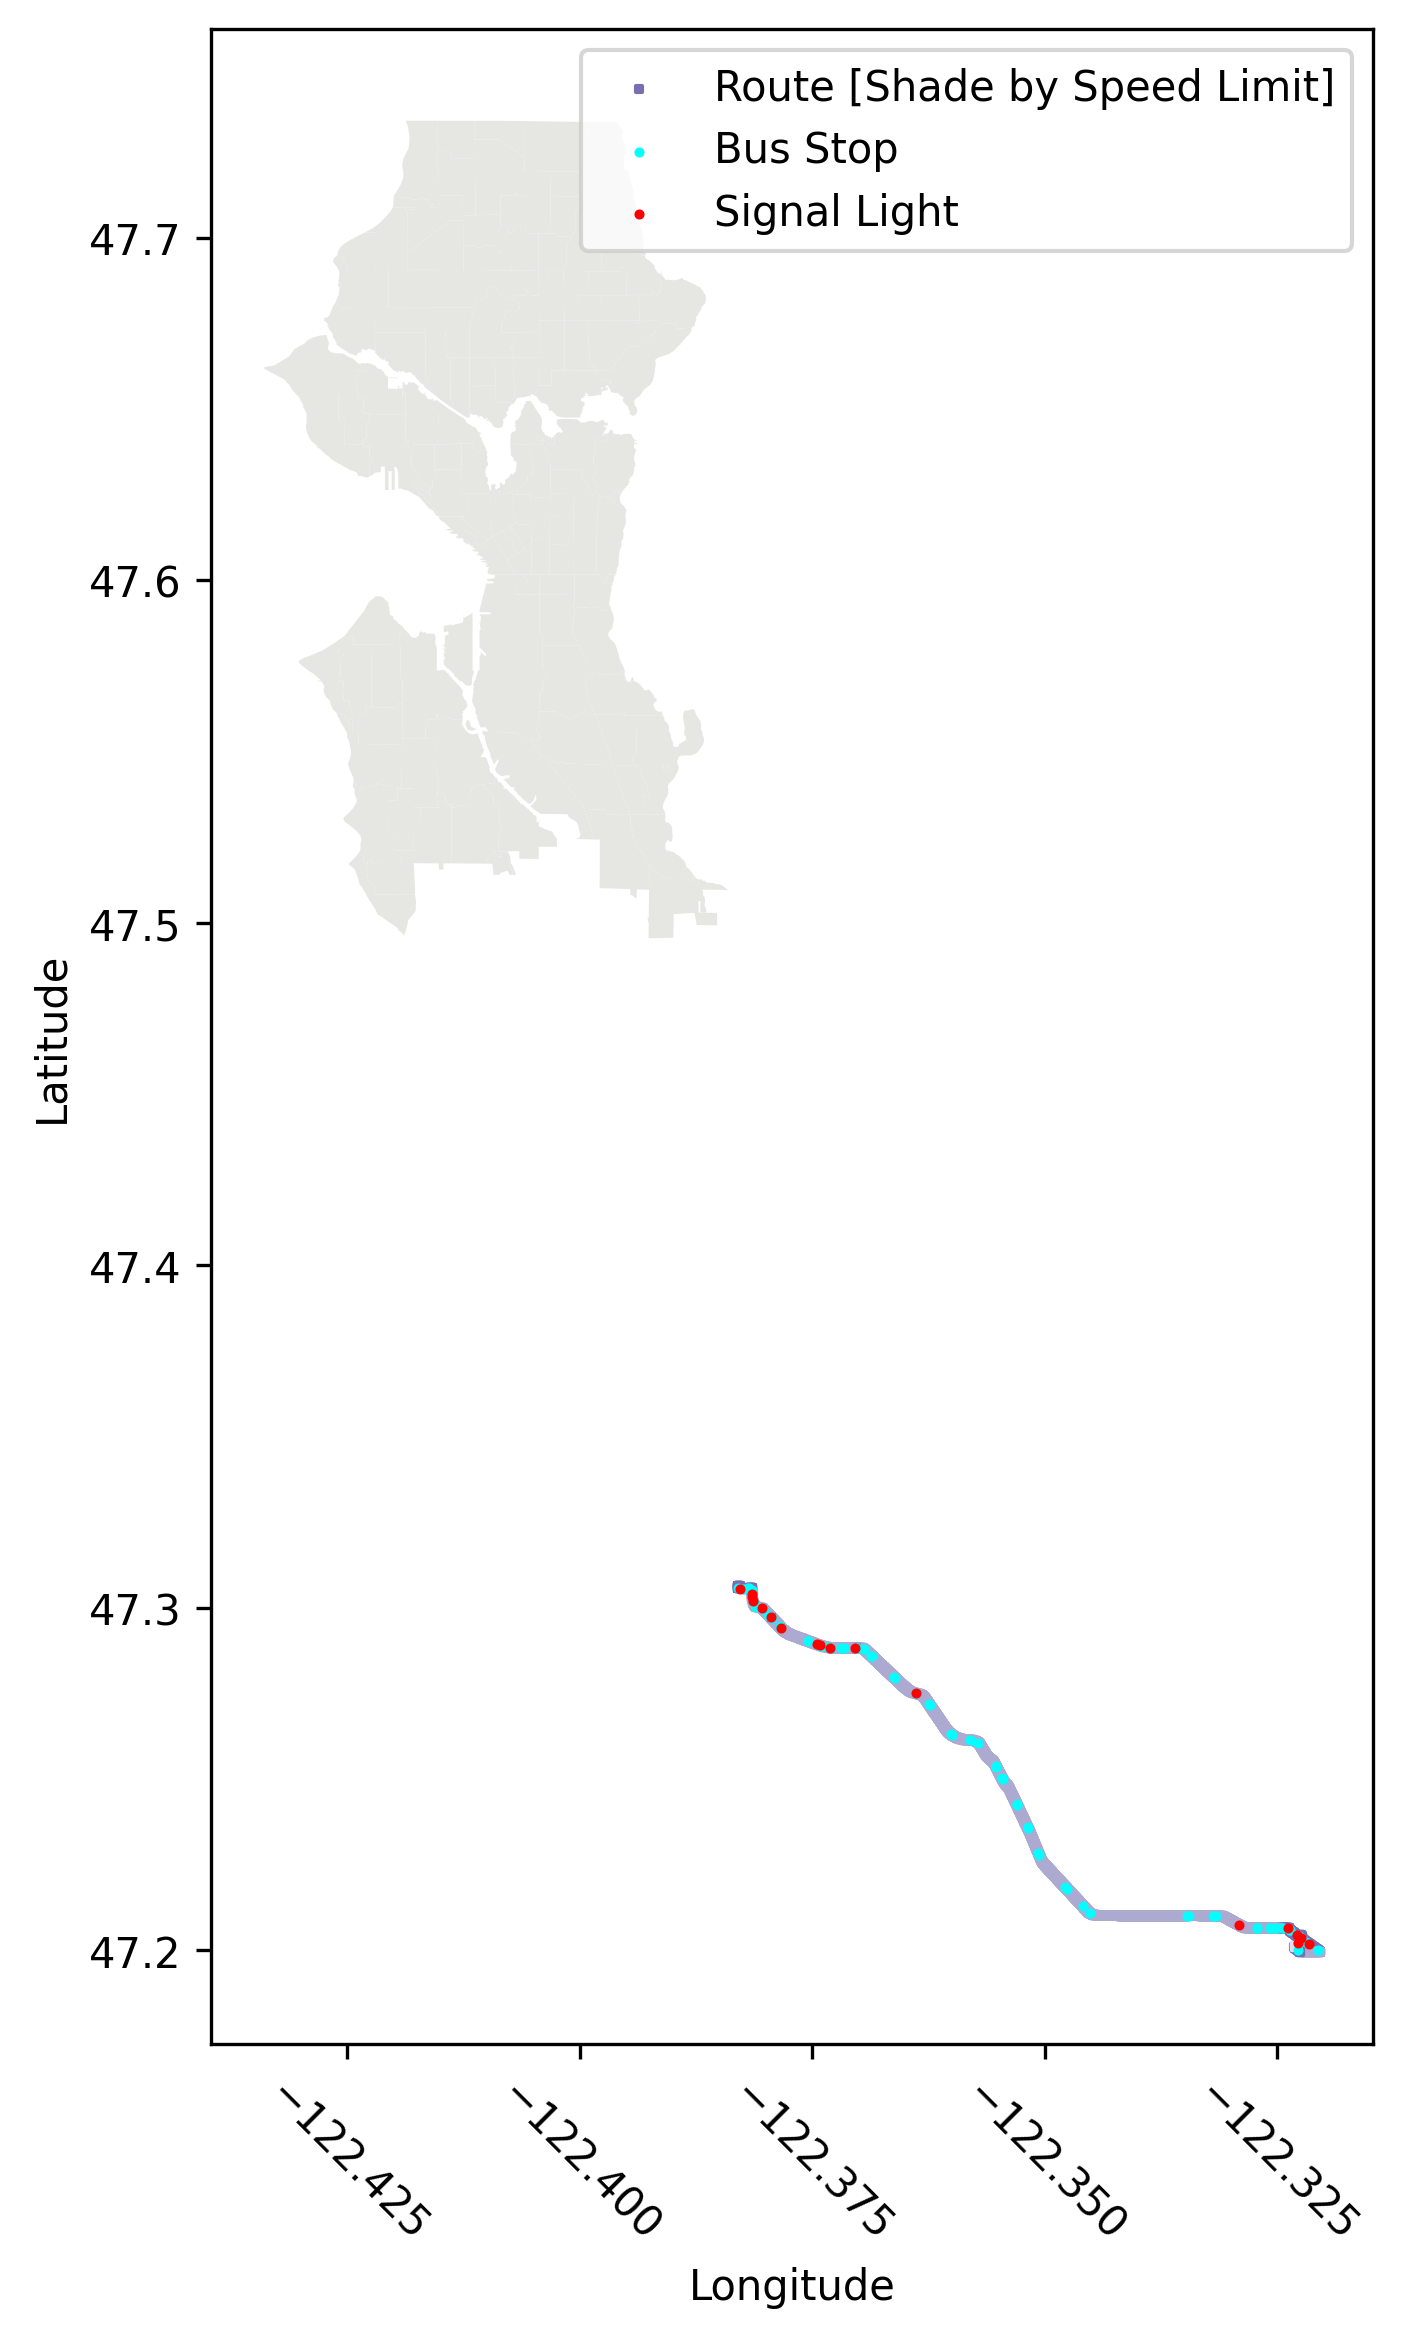

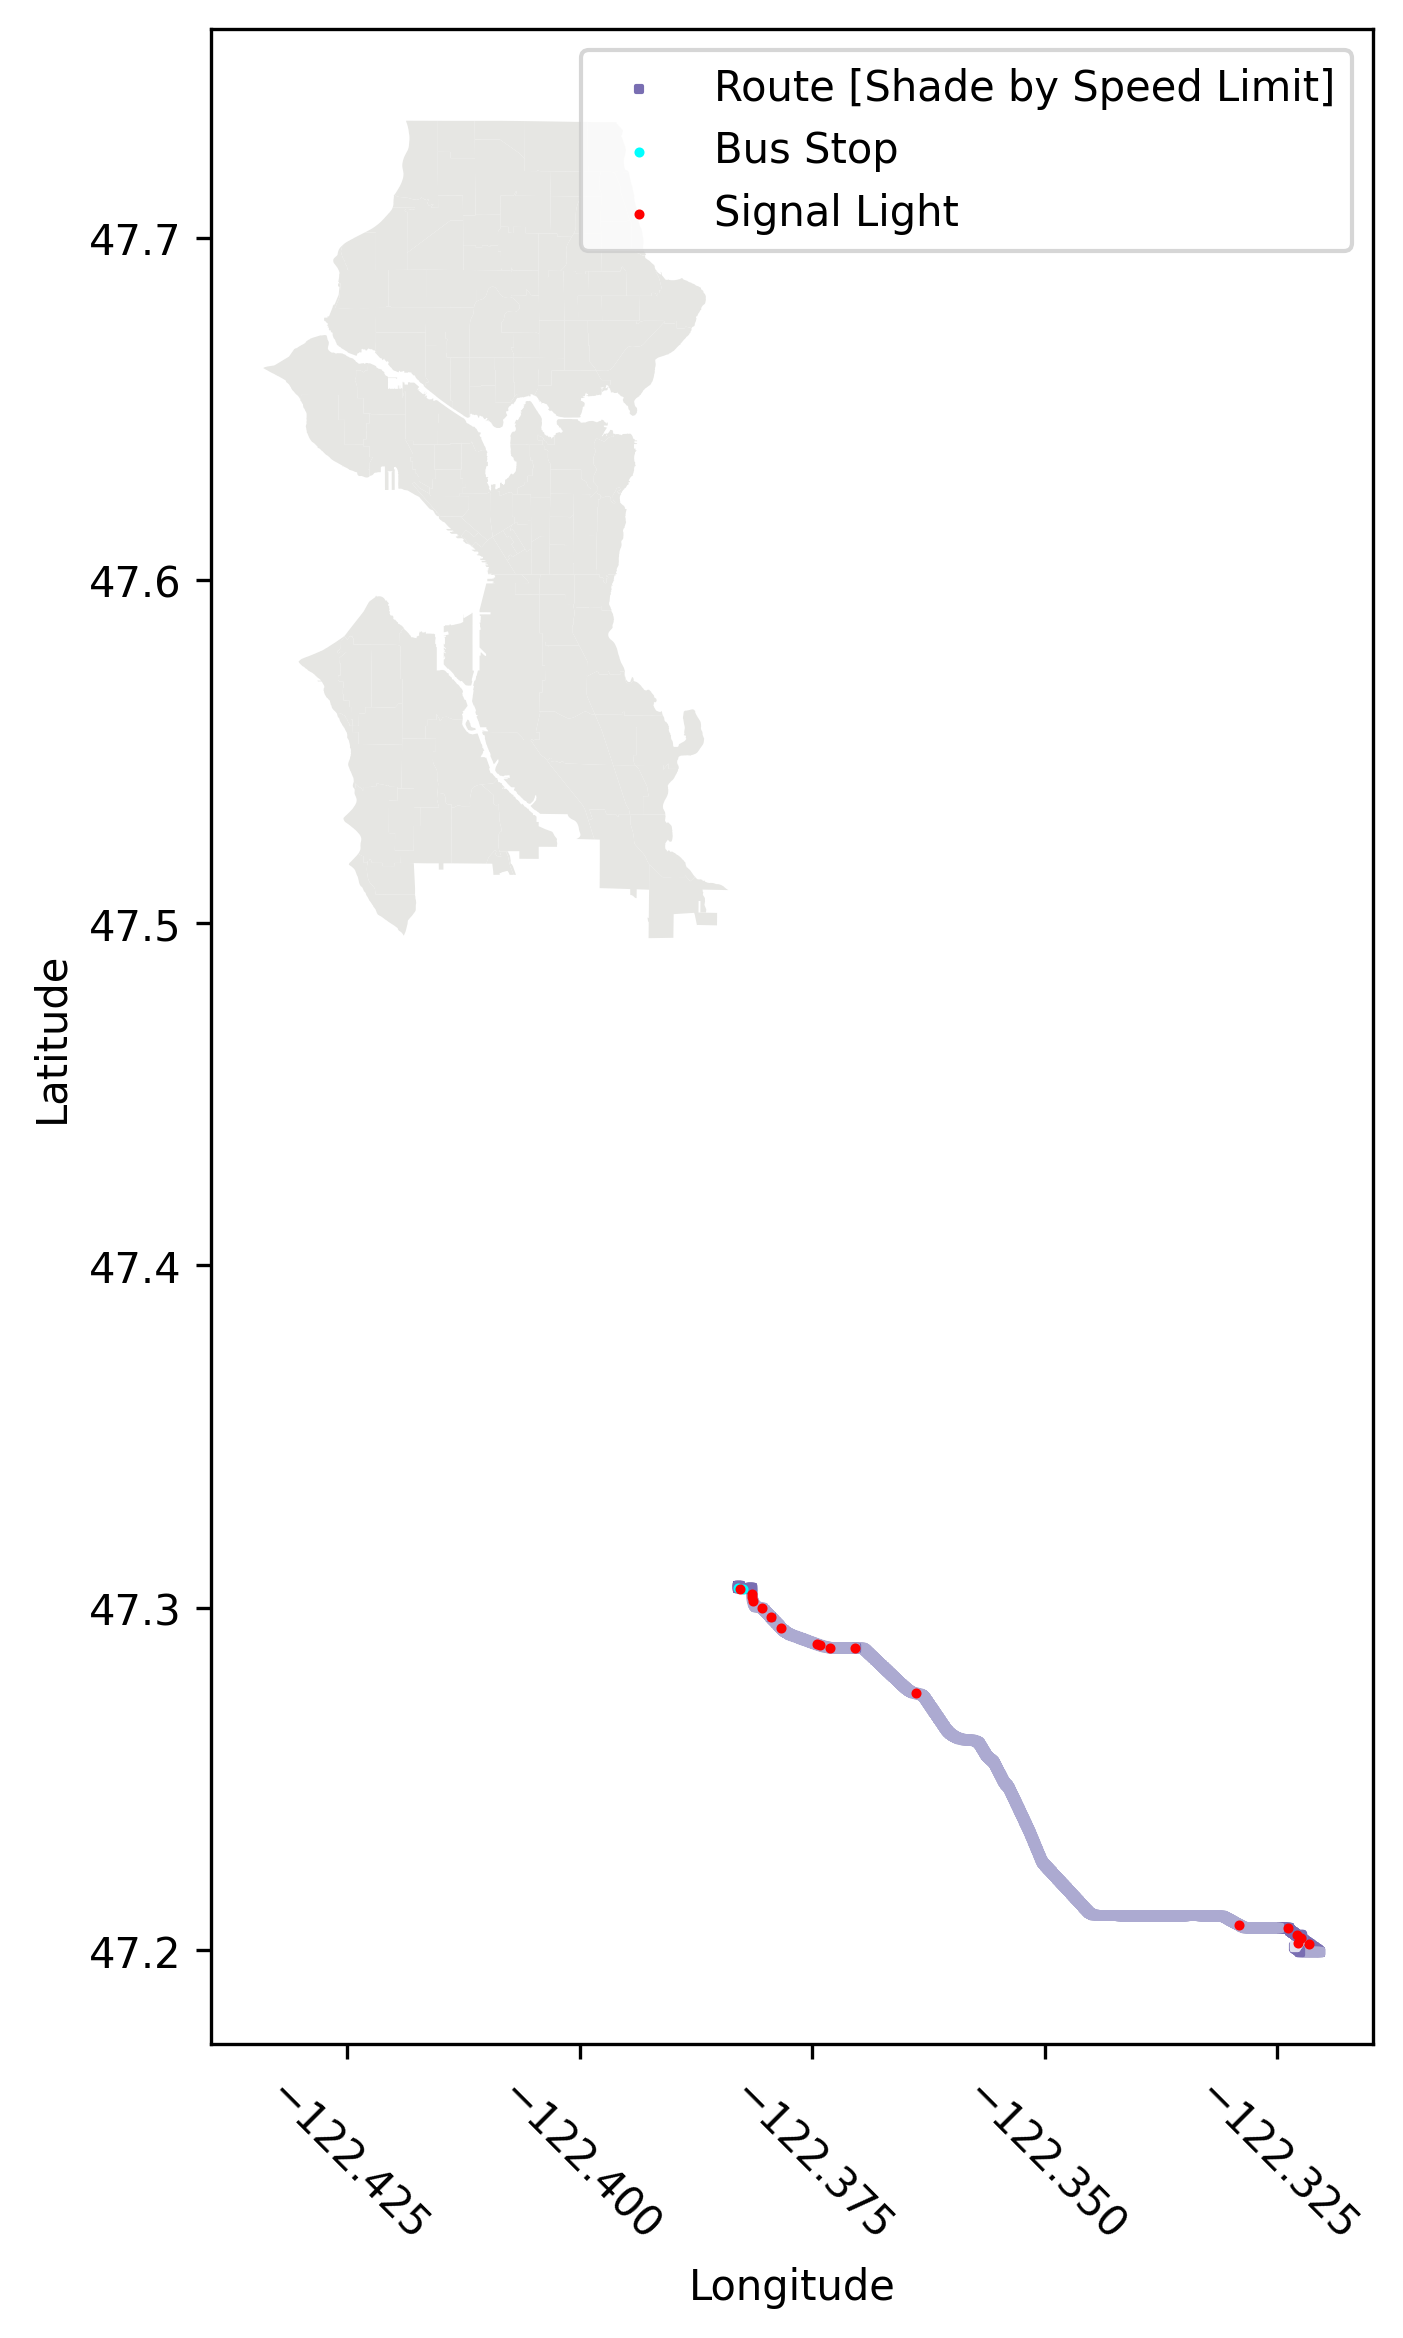

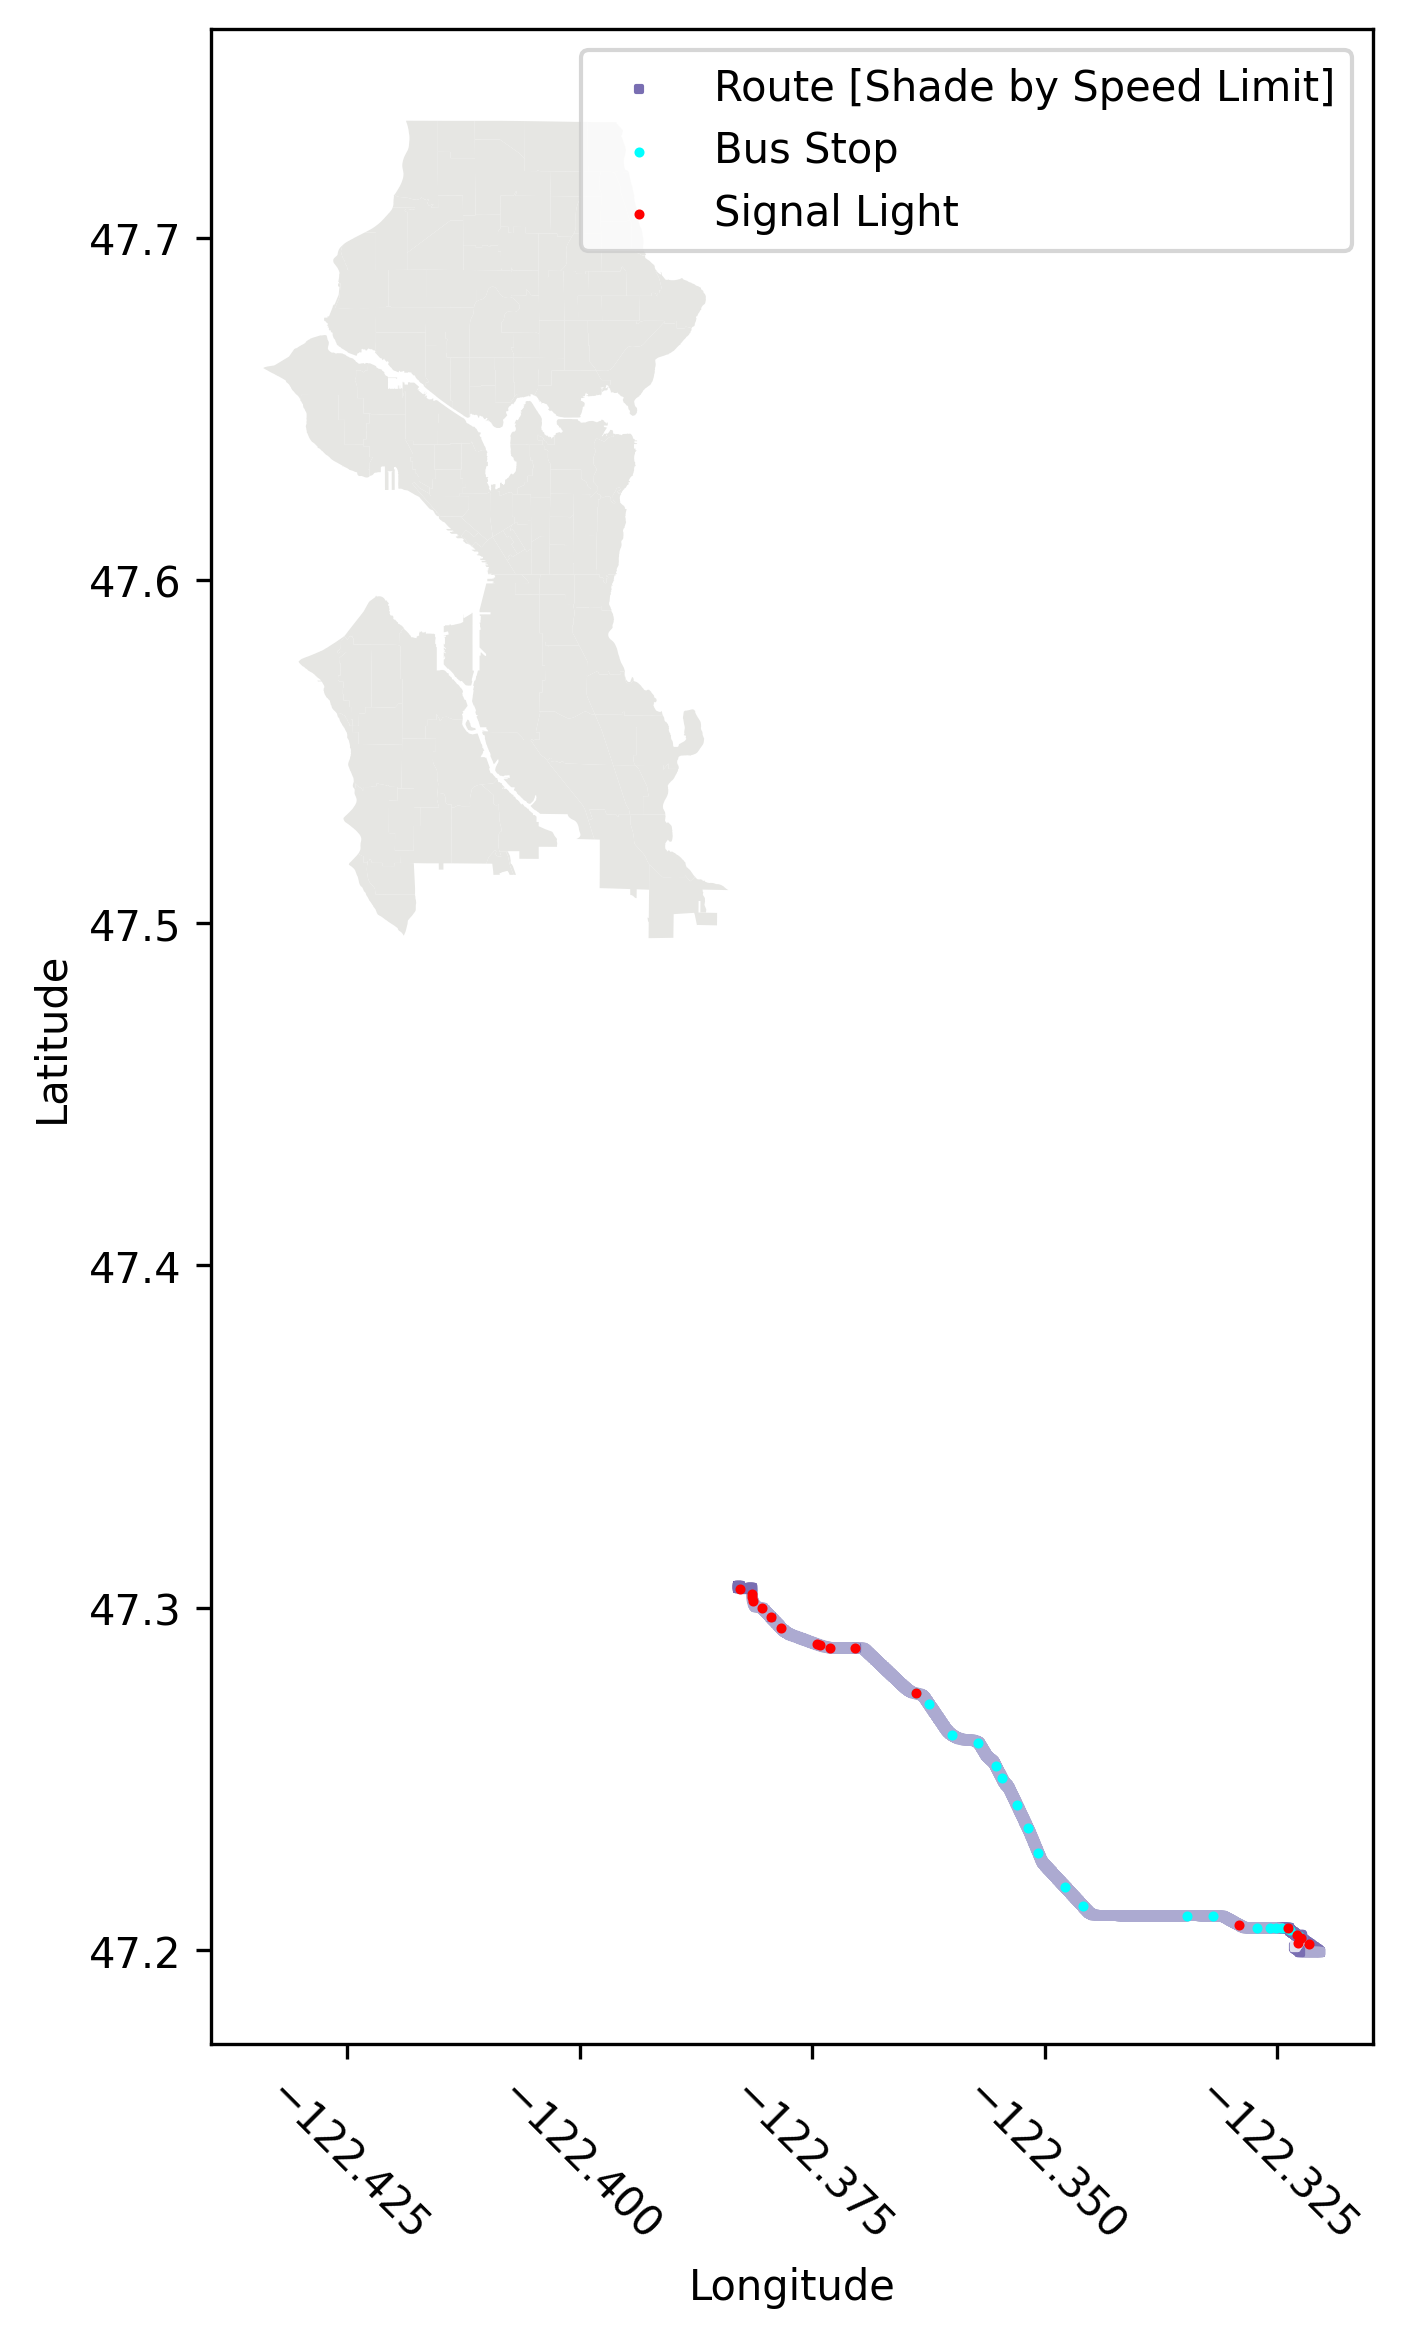

In [80]:
for route in list(data_dict_list.keys()):
    period_maps = data_dict_list[route]['map']
    print(route)
    for period in period_maps.keys():
        fig, ax = plt.subplots(1, figsize = (5,10), dpi=300)

        seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=-45)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        print(period)
        a_map = period_maps[period].get_gdf()
        a_map.plot(column='speed_limit[km/s]',
                          markersize=2,
                          ax=ax,
                          alpha=1,
                          zorder=10,
                          marker='s',
                          cmap = 'Purples_r')
        a_map[a_map['is_stop'] == True].plot(color='cyan',
                                             markersize=2,
                                             ax=ax,
                                             zorder=15)
        a_map[a_map['is_signal'] == True].plot(color='red',
                                               markersize=2,
                                               ax=ax,
                                               zorder=20)
        ax.legend(['Route [Shade by Speed Limit]', 'Bus Stop', 'Signal Light'])
        plt.savefig('rt_{}_{}_map.png'.format(route, period))

In [63]:

elev_raw = data_dict_list['22']['map'].get_elevation()
elev_smooth = data_dict_list['22']['map'].smooth_elevation()
dist = data_dict_list['22']['map'].get_gdf()['cumulative_distance[km]']
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].fill_between(dist, elev_raw, color = '#BDBDBD')
ax[1].fill_between(dist, elev_smooth, color = '#BDBDBD')
reg_elev_map = data_dict_list['22']['map'].set_elevation(elev_raw)
ax[0].set_xlabel('Distance [km]')
ax[1].set_xlabel('Distance [km]')
ax[0].set_ylabel('Elevation [km]')
ax[1].set_ylabel('Elevation [km]')
plt.savefig('elev_compare.png')

AttributeError: 'dict' object has no attribute 'get_elevation'

In [40]:
import BusModel as bm
acc_prof_path = "./Data/Accel_Prof/acceleration.csv"
raw_acc_prof = pd.read_csv(acc_prof_path, names=['time[s]', 'accel.[g]'])

# Make a duplicate to alter
a_prof = raw_acc_prof.copy()
# Convert g's to m/s^2 and then drop g's
a_prof['accel.[m/s^2]'] = a_prof['accel.[g]'] * 9.81
a_prof = a_prof.drop(columns = ['accel.[g]'])

default_bus = bm.BusModel(a_prof)

In [41]:
import TripDynamics as td

### TripDynamics Debugging

In [42]:
import random
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import RouteMap as rm

class TripDynamics:
    def __init__(self,
                 route_map,
                 bus_model,
                 bus_ridership,
                 braking_aggresion = 1, # default 1 based on maximum braking aggression
                 ridership_type='mean', # means how the ridership is taken, mean passengers on/off, or chance of passenger on/off. Chance currently unsure how to use.
                 seed=42, # life, the universe, and everything
                 stoplight_chance = .84615): # Defuault based on 120s cycle, 55s g, 65 red/yellow. https://wsdot.wa.gov/travel/operations-services/traffic-signals:
        self._route_map = route_map
        self._bus_model = bus_model
        self._ridership_type = ridership_type 
        self._rand_seed = seed
        self._braking_aggression = braking_aggresion 
        self._stoplight_chance = stoplight_chance
        
        # Check ridership type
        if (self._ridership_type == 'mean'):
            self._ridership = bus_ridership
        elif (self._ridership_type == 'chance'):
            self._ridership = self.riders_from_chance(bus_ridership)
        
        # generate gdf, ridership, and bus mass
        self._route_data = self._route_map.get_gdf()
        self._route_data['riders'] = self.generate_rider_profile()
        self._route_data['bus_mass'] = self.generate_mass_profile()
        
        self._trip_data = None
        
    
    def generate_rider_profile(self):
        '''
        generate_rider_profile generates a pandas series that contains the
        current amount of riders based on bus position
        
        Parameters:
        None
        
        Returns:
        pandas series matching length of route, with ridership numbers.
        Indicies identical to the route.
        '''
        
        # Copy the ridership changes as d_riders
        d_riders = self._ridership.copy()
        
        # get the series of stop booleans for the route
        stop_bools = self._route_data['is_stop'].copy()
        
        # create a new dataframe based on the stop booleans
        df = pd.DataFrame(stop_bools, columns=['is_stop'])
        
        # default change in riders is 0
        df['d_riders'] = 0
        
        # get a list of indexes on the route that are stops
        stop_indexes = list(df[df['is_stop']==True].index)
        
        # At the stops, add the change in riders
        df.iloc[stop_indexes, df.columns.get_loc('d_riders')] = None
        df.iloc[stop_indexes, df.columns.get_loc('d_riders')] = d_riders
        
        
        # make the cumulative riders and return it
        df['riders'] = df['d_riders'].cumsum()
        
        # Assign a class variable for ridership change
        self._ridership_change = df['d_riders']
        
        return df['riders']
    
    

    def generate_mass_profile(self):
        '''
        generate_mass_profile generates a pandas series
        containing the total bus mass at each point along
        the trip, based on the ridership information of the route.
        
        Parameters:
        None
        
        Returns:
        a pandas series containing the total bus mass
        at each point on the route, indexed the same.
        '''
        
        # Copy the stops and riders
        stop_bools = self._route_data['is_stop'].copy()
        n_riders = self._route_data['riders'].copy()
        
        # Generate a new dataframe from the stop booleans
        df = pd.DataFrame(stop_bools, columns=['is_stop'])
        
        # Add the default bus mass to the dataframe
        df['total_mass'] = self._bus_model.get_mass()
        
        # add the ridership column to the dataframe
        df['n_riders'] = n_riders
        
        # get stop indexes
        stop_indexes = df[df['is_stop']==True].index
        
        # Get the column indexes of mass and riders
        mass_col_id = df.columns.get_loc('total_mass')
        rider_col_id = df.columns.get_loc('n_riders')
        
        # Loop through each stop,
        for i in range(len(stop_indexes)):
            
            # Get the current route point index
            cur_idx = stop_indexes[i]
            
            # get the ridership value for this index
            rider_val = df.iloc[cur_idx, rider_col_id]
            
            # Set the bus model's riders to the rider value
            self._bus_model.update_riders(rider_val, 'set')
            
            # Get the mass of the bus model
            df.iloc[cur_idx:, mass_col_id] = self._bus_model.get_mass()
        
        # return the total mass series
        return df['total_mass']

    
    def get_mass_profile(self):
        return self._route_data['bus_mass']
    

    def bus_trip(self):
        '''
        bus_trip uses the route data and bus information to simulate the bus
        travelling according to a set logic, and returns the route geodataframe with new information
        on acceleration, time, and velocity.
        
        Parameters:
        None
        
        Returns:
        the geodataframe of all data involved in the process
        '''
        
        # get the route geodataframe
        route = self._route_map.get_gdf()
        
        # get the frictional acceleration profile of the route
        fric_a_prof = self._route_map.get_fric_accel()
        
        # get the hill accelerational profile of the route
        hill_a_prof = self._route_map.get_hill_accel()
        
        # get the bus model
        bus = self._bus_model
        
        # get the friction coefficient of the bus model
        bus_f_coef = bus.get_fric_coeff()
        
        # get the maximum velocity for the defined bus
        max_v = bus.max_velocity()
        
        # variable for how hard the driver presses on the brake while braking
        braking_factor = self._braking_aggression
        
        # define new columns for velocity, stop distance, state, and stopping distance,
        # Power needed, and time change.
        route['vel.[m/s]'] = 0
        route['acc.[m/s^2]'] = 0
        route['stop_dist[m]'] = 0
        route['stppn_dist'] = 0
        route['power_needed[W]'] = 0
        route['st'] = 0
        route['time_change[s]'] = 0
        route['r_change'] = abs(self._ridership_change) > 0
        
        # Generate empty lists to hold the same values as above.
        vel_list = []
        acc_list = []
        dist_list = []
        stp_d_ls = []
        power = []
        st_ls = []
        dt_ls = []
        
        # get the accelerational profile of the bus.
        accel_profile = bus.get_accel_profile()
        
        # Set the random seed
        random.seed(self._rand_seed)
        
        # Set up the final point of the route so that the bus actually stops there.
        route.at[len(route)-2,'is_stop'] = True
        route.at[len(route)-2, 'r_change'] = True
        
        # Loop through each point on the route
        for i in range(1, len(route)-1):
            
            # update the bus's mass.
            current_mass = self._route_data['bus_mass'][i]
            bus.update_mass(current_mass)
            
            # get the current point distance in meters
            point_dist = route['point_distances[km]'][i]*1000 # convert to meters
            
            # get the cumulative distance travelled to this point in meters
            cum_dist = route['cumulative_distance[km]'][i]*1000 # convert to meters
            
            # get the cumulative distance column id
            cum_dist_col_id = route.columns.get_loc('cumulative_distance[km]')
            
            # get the dataframe containing the remaining points that have not been visited
            remaining_trip = route.iloc[i:]
            
            # set the distance to the stop to a dummy variable of 0
            dist_to_stop = 0
            
            # set the index of the next stop to dummy variable of 0
            next_stop_index = 0
            
            # Set up a boolean for checking if the bus will stop. range based on closest integer to the inverse fraction provided
            is_stopping = (random.randrange(int(round(1/self._stoplight_chance),0)) == 0)
            
            # get the list of stops as defined by the distance between each stop on the route,
            #including signals, in meters
            #                                    Check if it's a stop and that stop has a ridership change         or      check if its a signal and the bus is stopping
            stops_remain = remaining_trip[((remaining_trip['is_stop'] == True) & remaining_trip['r_change'] == True)| ((remaining_trip['is_signal'] == True) & is_stopping)]['cumulative_distance[km]'].reset_index(drop=True)*1000 #convert to meters

            # if there are remaining stops,
            if (len(stops_remain) != 0):
                
                # set the distance to the stop to be the difference between the stop distance
                # and cumulative distance
                dist_to_stop = stops_remain[0]-cum_dist # meters
                
                # set the next stop index, handle errors where for some reason there is no value for cumulative distance.
                next_stop_match = route['cumulative_distance[km]'][route['cumulative_distance[km]'] == stops_remain[0]/1000]
                if (len(next_stop_match) != 0):
                    next_stop_index = route['cumulative_distance[km]'][route['cumulative_distance[km]'] == stops_remain[0]/1000].index[0]
                else:
                    # if there's nothing, assume the next stop index is in the next 10.
                    next_stop_index = i+10
                
            # get the current velocity of the bus
            start_velocity = bus.velocity()  
            
            # get the acceleration of bus friction at the point
            a_fric = fric_a_prof[i]*bus_f_coef
            
            # get the acceleration due to gravity at the point
            a_hill = hill_a_prof[i]
            
            # combine the accelerations to get external (to the bus's motor) acceleration
            ext_a = a_fric + a_hill 
            
            # calculate the stopping distance based on the starting velocity and external acceleration
            stopping_dist = bus.get_braking_distance(start_velocity, braking_factor, ext_a) #meters
            
            # get the speed limit at current point
            point_sp_lim = route['speed_limit[km/s]'][i] * 1000 # meters
            
            # Error correction for when speed limit has noise
            stable_limit = True
            if (i > 2 and i < len(route)-2):
                # get a boolean for if any change in speed limit is stable:
                mean_limit = (route['speed_limit[km/s]'][i-1:i+1]*1000).mean()
                stable_limit = abs(point_sp_lim - mean_limit) < .1
                point_sp_lim = mean_limit
            
            # set up a variable for status
            status = ""
            d_power = 0
            d_t = 0
            
            # Driving logic: -------------------------------------------------------
            #If at rest, accelerate for the distance between this and the next point
            if (start_velocity < 0.1):
                status = "accel_from_0"
                d_power, d_t = bus.accelerate_v5(point_dist, ext_a)
                
            # If the distance difference between stopping distance and distance to the stop
            # is less than half the point distance resolution, then brake
            
            elif ((dist_to_stop < (stopping_dist + point_dist))): #and (abs(self._ridership_change[next_stop_index]) > 0)):
                status = "Stopping_brake"
                d_power, d_t = bus.brake_v3(point_dist, braking_factor, ext_a)
            #elif((dist_to_stop-stopping_dist)<= point_dist):
                
            # If the starting velocity is less than the speed limit, accelerate. Margin is 1/25th of speed limit.
            elif(start_velocity < (point_sp_lim - point_sp_lim/25)):
                status = "speed_lim_accel"
                d_power, d_t = bus.accelerate_v5(point_dist, ext_a)
                
            # if the starting celocity is greater than the speed limit, 
            elif(start_velocity > (point_sp_lim+point_sp_lim/25)):
                status = "speed_lim_brk"
                
                # brake for that distance
                d_power, d_t = bus.brake_v3(point_dist, braking_factor-.4, ext_a)
            else:
                status = "maintain_v"
                d_power, d_t = bus.maintain_v5(point_dist, ext_a)
            # End driving logic ---------------------------------------------------------
            
            
            # Append all the statuses and data to their lists
            st_ls.append(status)
            vel_list.append(bus.velocity())
            acc_list.append(bus.get_acceleration())
            dist_list.append(dist_to_stop)
            stp_d_ls.append(stopping_dist)
            power.append(d_power)
            dt_ls.append(d_t)
        
        # convert the lists and apply them to the respective columns
        route.iloc[1:-1, route.columns.get_loc('vel.[m/s]')] = vel_list
        route.iloc[1:-1, route.columns.get_loc('acc.[m/s^2]')] = acc_list
        route.iloc[1:-1, route.columns.get_loc('stop_dist[m]')] = dist_list
        route.iloc[1:-1, route.columns.get_loc('stppn_dist')] = stp_d_ls
        route.iloc[1:-1, route.columns.get_loc('power_needed[W]')] = power
        route.iloc[1:-1, route.columns.get_loc('st')] = st_ls
        route.iloc[1:-1, route.columns.get_loc('time_change[s]')] = dt_ls
        
        route['elapsed_time[s]'] = route['time_change[s]'].cumsum()
        
        # Set the route GDF to an instance variable, then return it.
        self._trip_data = route
        return route
    
    
    def get_all_data(self):
        '''
        get_all_data returns the dataframe generated after a trip is performed.
        
        Parameters:
        N/A
        
        Returns: 
        Dataframe of Trip data, or None if no trip has been performed.
        '''
        if (self._trip_data is None):
            print("Warning, bus_trip() method has not yet been used!")
        return self._trip_data
      
        
    def generate_ESS_profile(self):
        '''
        generate_ESS_profile() is a method to create the Energy Storage System
        power profile based on the required power. Note: This requires bus_trip()
        to be run prior.
        
        Parameters:
        N/A
        
        Returns:
        Pandas series containing required power from the ESS.
        '''
        # Get the trip data's power requirements
        power_profile = self.get_all_data()['power_needed[W]']
        
        # Apply the instance power method to the power profile.
        ESS_profile = power_profile.apply(self.calc_instance_power)
        
        # Return the profile.
        return ESS_profile
    
    
    def calc_instance_power(self, value):
        '''
        calc_instance_power takes in a power value,
        and converts it to the corresponding load on the ESS.
        
        Parameters:
        value: a power value in Watts, as an int or float.
        
        Returns:
        converted battery power as a float.
        '''
        # Get the bus model parameters.
        motor_eff = self._bus_model.get_motor_eff()
        invert_eff = self._bus_model.get_invert_eff()
        aux_eff = self._bus_model.get_auxill_efficiency()
        aux_load = self._bus_model.get_aux_load()
        regen_eff = self._bus_model.get_regen_eff()
        max_regen = -100000
        
        # set the battery power to zero.
        bat_pow = 0
        
        # Including Auxilliary load, though not strictly important at the moment. 
        if (value >= 0):
            # Discharging, converting the needed power into power battery must exert
            bat_pow = value/(motor_eff*invert_eff) + (aux_load/aux_eff)
        elif(value*regen_eff*motor_eff > max_regen):
            #charging, the regenerative braking ALL the time, max regen is 100
            bat_pow = value*regen_eff*motor_eff + (aux_load/aux_eff)
        else:
            bat_pow = max_regen + (aux_load/aux_eff)
            
            
        # Return the battery power.
        return bat_pow
    
    
    def export_trip_data(self):
        '''
        export_trip_data generates a geodataframe with the most relevant informaton for
        ease of use and understanding. For a hollistic report, get_all_data is better suited.
        
        Parameters:
        N/A
        
        Returns:
        geodataframe containing trip geometry, elevation, distance, grade, ridership, mass, velocity,
        elapsed time, and power needed in Watts. 
        '''
        # Drop non-relevant columns.
        raw_trip_data = self.get_all_data().copy()
        raw_trip_data.drop("stop_dist[m]", axis='columns', inplace=True)
        raw_trip_data.drop("stppn_dist", axis='columns', inplace=True)
        raw_trip_data.drop("power_needed[W]", axis='columns', inplace=True)
        raw_trip_data.drop("is_stop", axis='columns', inplace=True)
        raw_trip_data.drop("is_signal", axis='columns', inplace=True)
        raw_trip_data.drop("point_distances[km]", axis='columns', inplace=True)
        raw_trip_data.drop("latitude", axis='columns', inplace=True)
        raw_trip_data.drop("longitude", axis='columns', inplace=True)
        raw_trip_data.drop("speed_limit[km/s]", axis='columns', inplace=True)
        
        # Add the ESS profile.
        raw_trip_data['power_needed[W]'] = self.generate_ESS_profile()
        
        # return the trip data.
        return raw_trip_data

### Run TripDynamics

In [43]:
data_dict_list['22'].keys()

dict_keys(['geometry', 'elevation', 'ridership', 'stops', 'map'])

In [44]:
for route in list(data_dict_list.keys())[:]:
    smellev = data_dict_list[route]['map'].smooth_elevation()
    prev_elev = data_dict_list[route]['map'].get_elevation()
    smoothed_elev_map = data_dict_list[route]['map'].set_elevation(smellev)
    data_dict_list[route]['trip']={}
    for period in list(data_dict_list[route]['ridership'].keys())[:]:
        print(route, period)
        riders = data_dict_list[route]['ridership'][period]
        bus = bm.BusModel(a_prof)
        trip = TripDynamics(smoothed_elev_map, bus, riders)
        data_dict_list[route]['trip'][period]=trip
        
    reg_elev_map = data_dict_list[route]['map'].set_elevation(prev_elev)
    

22 XEV
22 AM
22 MID
22 PM
186 AM
186 XEV
186 PM
186 MID
186 XNT


KeyError: 'map'

In [34]:
data_dict_list.keys()

dict_keys(['22', '186', '101'])

In [140]:
data_dict_list['186'].keys()

dict_keys(['geometry', 'elevation', 'ridership', 'stops'])

In [133]:
len(data_dict_list['186']['ridership']['XNT'])

19

In [134]:
len(data_dict_list['186']['stops']['XNT'])

19

In [52]:
len(data_dict_list['101']['ridership']['AM'])

42